# Base imports and functions

In [2]:
!pip install --upgrade tensorflow_hub

In [3]:
!pip install --upgrade tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [4]:
%%capture
!pip install wandb

In [5]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
from sklearn.utils import class_weight
import pandas as pd
import datetime
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image


In [8]:
import cv2
from google.colab.patches import cv2_imshow
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [9]:
from keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

In [10]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_img = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img


In [11]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving to: {log_dir}")
  return tensorboard_callback

In [12]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed.
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [13]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [15]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [16]:
def create_model (model_url, num_classes, width, height):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           dtype=tf.float32,
                                           name="feature_extraction_layer",
                                           input_shape = (width,height,3))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="sigmoid", name="output_layer")
  ])
  return model

In [17]:
def pred_and_plot(model, filename, true_label, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = filename

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  for i in range(len(class_names)):
    print(f"Prediction: {class_names[i]} {pred[0][i]*100:.2f}%, True: {true_label[i]}")

  # predicted_labels = [class_names[i] for i in range(len(class_names)) if pred[0][i] >= 0.5]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.axis(False);

In [18]:
def plot_multi_label_confusion_matrix(true_labels, predicted_labels, class_labels):
    # Calculate the confusion matrix
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

    num_classes = len(class_labels)
    num_cols = 3  # Fixed number of columns
    num_rows = (num_classes + num_cols - 1) // num_cols  # Calculate the number of rows needed for plotting

    # Plot the confusion matrix
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            class_index = i * num_cols + j
            if class_index < num_classes:
                ax.imshow(conf_matrix[class_index], cmap='Blues', interpolation='nearest')
                ax.set_title('Macierz błędów dla {}'.format(class_labels[class_index]))
                ax.set_xticks([0, 1])
                ax.set_yticks([0, 1])
                ax.set_xticklabels(['Predicted: 0', 'Predicted: 1'])
                ax.set_yticklabels(['True: 0', 'True: 1'])

                for k in range(2):
                    for l in range(2):
                        ax.text(l, k, str(conf_matrix[class_index][k][l]), ha='center', va='center', color='red')
            else:
                ax.axis('off')  # Turn off empty subplots

    plt.tight_layout()
    plt.show()

In [19]:
def showF1scores(model_experiment, test_gen, class_names):
    pred = model_experiment.predict(test_gen, verbose=1)
    preds = np.where(pred < 0.5, 0, 1)

    classification_report_dict = classification_report(test_gen.labels, preds, output_dict=True)

    class_f1_scores = {}
    # Loop through classification report items
    for k, v in classification_report_dict.items():
        if k == "micro avg":  # stop once we get to accuracy key
            break
        else:
            # Append class names and f1-scores to new dictionary
            class_f1_scores[class_names[int(k)]] = v["f1-score"]

    f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                              "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figsize as needed
    scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
    ax.set_yticks(range(len(f1_scores)))
    ax.set_yticklabels(list(f1_scores["class_name"]))
    ax.set_xlabel("f1-score")
    ax.set_title("Metryka F1")
    ax.invert_yaxis()  # reverse the order

    autolabel(scores, ax)  # Call autolabel function with scores and ax objects

    plt.show()

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height (it's value).
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03 * width, rect.get_y() + rect.get_height() / 2.,
                f"{width:.2f}",
                ha='center', va='center')

In [20]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["f1_score"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_f1_score"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["f1_score"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_f1_score"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training f1_score')
    plt.plot(total_val_acc, label='Validation f1_score')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation f1_score')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Data import and preprocessing

In [21]:
import zipfile

my_files = zipfile.ZipFile("/content/drive/MyDrive/data_one_hot.zip")

my_files.extractall()
my_files.close()

In [22]:
df=pd.read_csv("/content/drive/MyDrive/Zebrafishmetadata_combined.csv", sep=',')
class_names = columns=["Curved spine", "Dead", "Edema", "Normal", "Unhatched", "Yolk deformation"]

In [23]:
print(df.head())

                        Filename  Curved spine  Dead  Edema  Normal  \
0                    1-3-006.jpg             0     0      0       1   
1        2_h2o2_dmso_72h-054.jpg             0     0      0       1   
2  4_beta_endosulfan_72h-015.jpg             0     0      0       1   
3    7_h2o2+apple ex_72h-028.jpg             1     0      0       0   
4                 E3-039 (2).jpg             0     0      0       1   

   Unhatched  Yolk deformation  
0          0                 0  
1          0                 0  
2          0                 0  
3          0                 1  
4          0                 0  


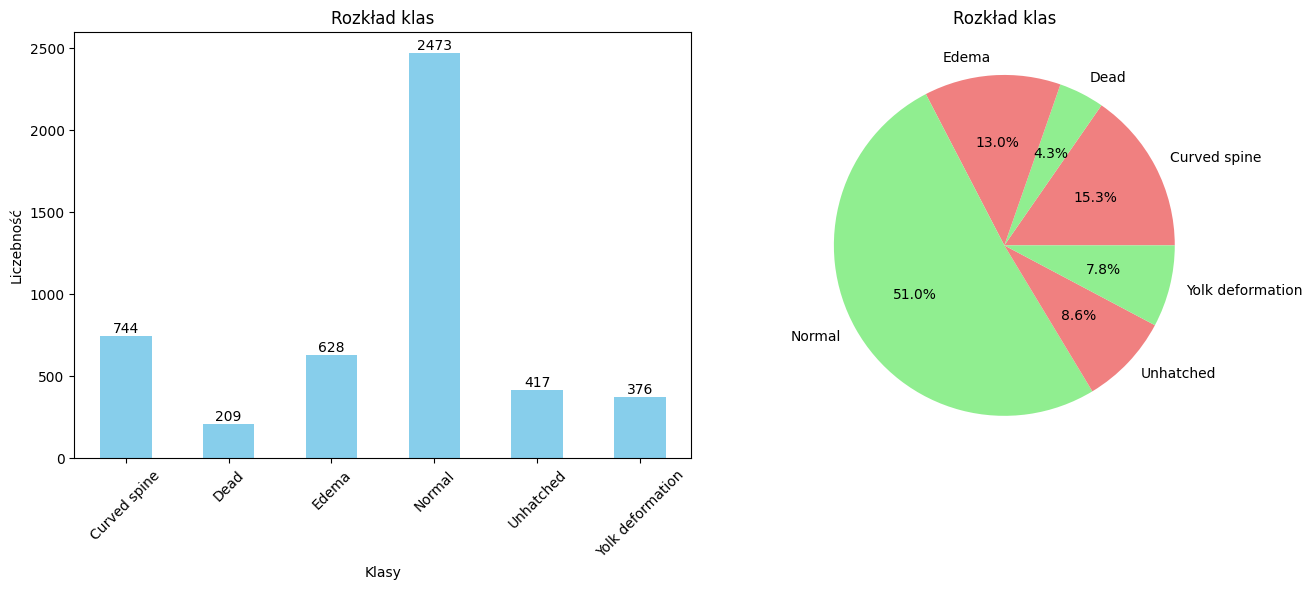

In [24]:
# Count occurrences of each class
class_counts = df.iloc[:, 1:].sum()

# Plot the distribution - Bar Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars = class_counts.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas')
plt.xlabel('Klasy')
plt.ylabel('Liczebność')
plt.xticks(rotation=45)

# Add counts on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Plot the distribution - Pie Chart
plt.subplot(1, 2, 2)
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Rozkład klas')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [79]:
img_height = img_width = 299
batch_size = 32

datagen=ImageDataGenerator(
    rescale=1.0/255.,
 )

datagen_augmented=ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=0.5,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_data = datagen.flow_from_dataframe(
  dataframe=df[:3387],
  directory="/content/data_one_hot/images",
  x_col="Filename",
  y_col=columns,
  batch_size=batch_size,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(img_height,img_width))

train_data_augmented=datagen_augmented.flow_from_dataframe(
  dataframe=df[:3387],
  directory="/content/data_one_hot/images",
  x_col="Filename",
  y_col=columns,
  batch_size=batch_size,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(img_height,img_width))

validation_gen=datagen.flow_from_dataframe(
  dataframe=df[3387:3763],
  directory="/content/data_one_hot/images",
  x_col="Filename",
  y_col=columns,
  batch_size=batch_size,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(img_height,img_width))

test_gen=datagen.flow_from_dataframe(
  dataframe=df[3763:],
  directory="/content/data_one_hot/images",
  x_col="Filename",
  y_col=columns,
  seed=42,
  shuffle=False,
  class_mode="raw",
  target_size=(img_height,img_width))

Found 3387 validated image filenames.
Found 3387 validated image filenames.
Found 376 validated image filenames.
Found 419 validated image filenames.


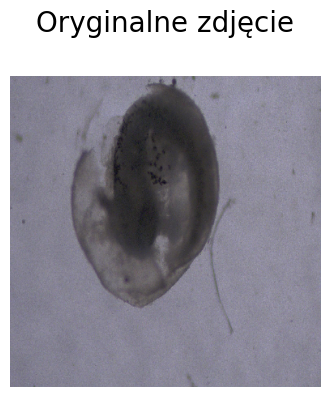

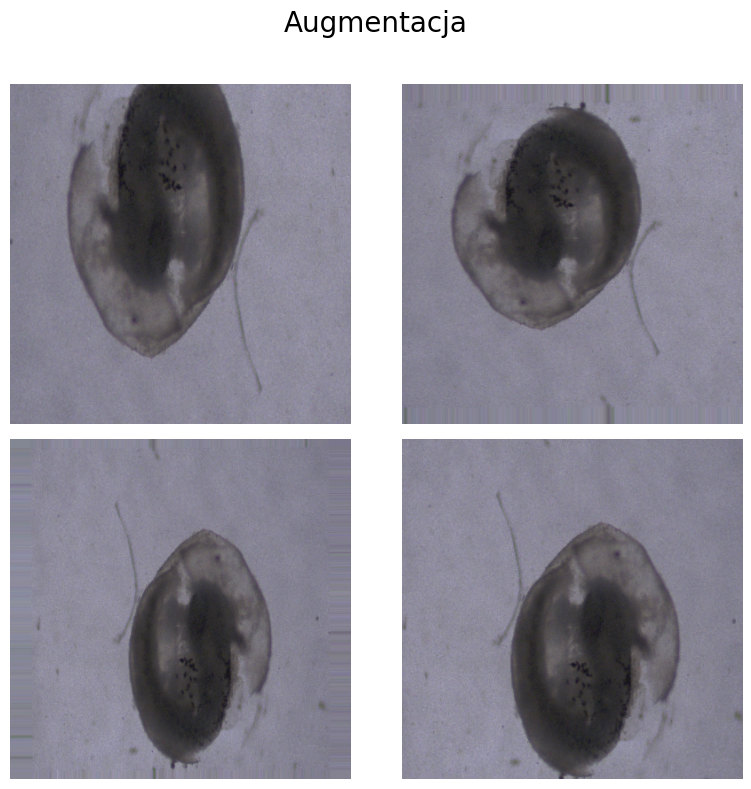

In [26]:
def plot_images_grid(images_arr, title, rows=1):
    cols = len(images_arr) // rows if len(images_arr) % rows == 0 else len(images_arr) // rows + 1
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    fig.suptitle(title, fontsize=20)

    # Ensure axes is always iterable
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()

    for i, ax in enumerate(axes.flat):
        if i < len(images_arr):
            ax.imshow(images_arr[i])
            ax.axis('off')
        else:
            fig.delaxes(ax)  # Remove empty subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

# Load a batch of original images
original_images, _ = next(train_data)

# Select one image from the batch
image = original_images[0]

# Generate augmented images
augmented_images = [datagen_augmented.random_transform(image) for _ in range(4)]

# Plot the original image
plot_images_grid([image], 'Oryginalne zdjęcie')

# Plot the augmented images in two rows
plot_images_grid(augmented_images, 'Augmentacja', rows=2)


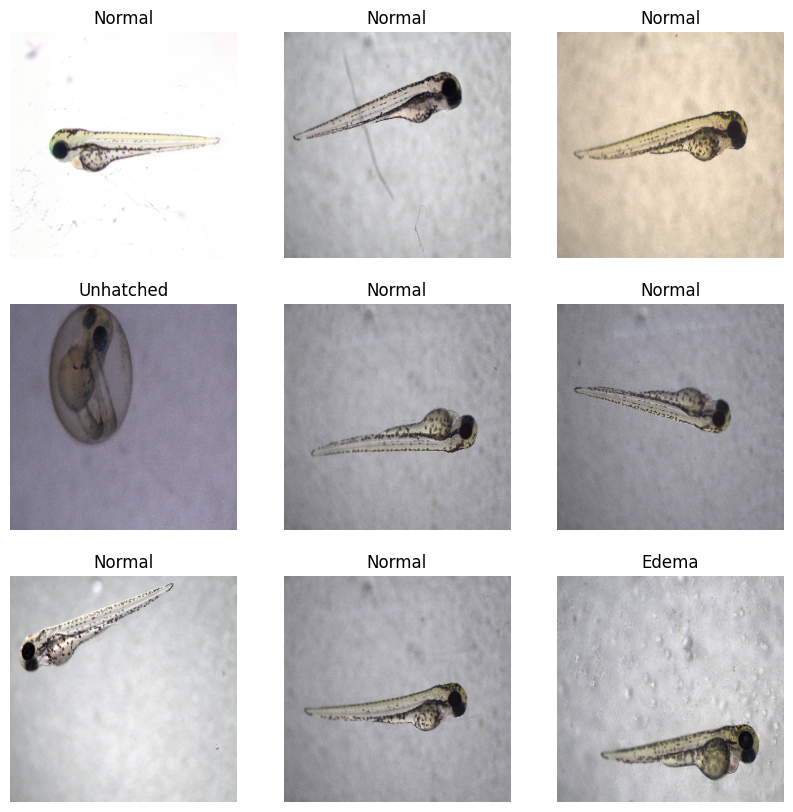

In [27]:
# Function to decode one-hot encoded labels
def decode_labels(one_hot_labels, columns):
    decoded_labels = []
    for one_hot_label in one_hot_labels:
        decoded_label = [column for column, value in zip(columns, one_hot_label) if value == 1]
        decoded_labels.append(decoded_label)
    return decoded_labels

# Get a batch of images and labels
images, one_hot_labels = train_data.next()

# Decode one-hot encoded labels
columns = ["Curved spine", "Dead", "Edema", "Normal", "Unhatched", "Yolk deformation"]
decoded_labels = decode_labels(one_hot_labels, columns)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Create a string representation of the decoded labels for the current image
    label_str = ', '.join(decoded_labels[i])

    plt.title(label_str)
    plt.axis("off")
plt.show()

In [80]:
augmented_images, augmented_labels = train_data_augmented.next()

In [81]:
train_images, train_labels = train_data.next()

In [82]:
test_images, test_labels = test_gen.next()

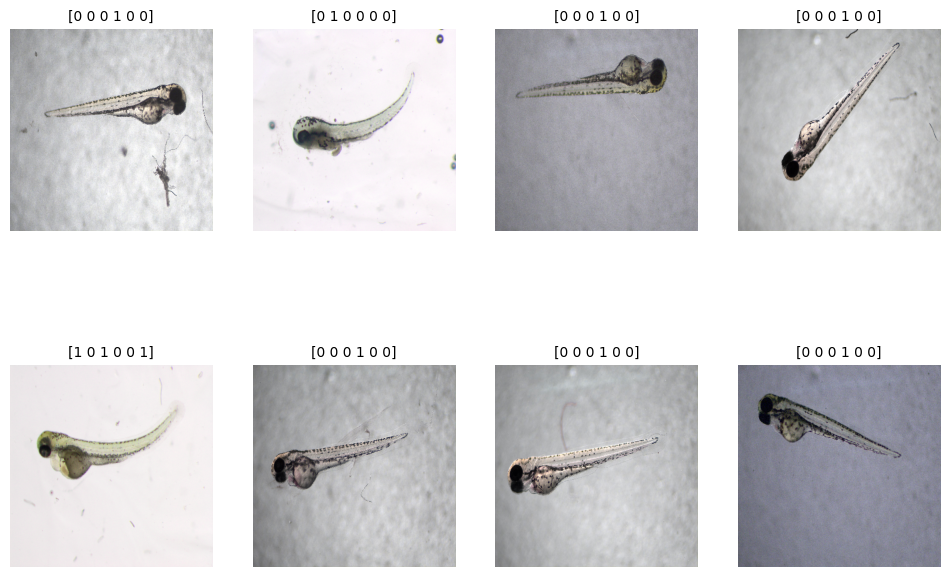

In [31]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):

    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(train_images[i])
    plt.title(str(f"{train_labels[i]}"), size=10)
    plt.axis('off')

In [32]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
      tfa.metrics.F1Score(num_classes=8, average='macro')
]

In [33]:
METRICS2 = [
      tfa.metrics.F1Score(num_classes=6, average='macro'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

In [34]:
class_weights_calc = generate_class_weights(train_labels, multi_class=False, one_hot_encoded=True)
print(class_weights_calc)

{0: 0.7619047619047619, 1: 2.6666666666666665, 2: 2.6666666666666665, 3: 0.2318840579710145, 4: 5.333333333333333, 5: 5.333333333333333}


Accuracy nie jest dobrym parametrem ewaluacji zbioru niezbalansowanego

In [35]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SimpleModel


In [ ]:
run = wandb.init(project="SimpleModel")

NameError: name 'wandb' is not defined

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [53]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [54]:
simple = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(384, 384, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(6, activation='sigmoid')
])


simple.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS2)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [55]:
history=simple.fit(
            train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            callbacks=model_earlystop_callback)

Epoch 1/15
106/106 [==============================] - 152s 1s/step - loss: 0.3924 - f1_score: 0.4210 - precision: 0.6107 - recall: 0.5497 - auc: 0.8342 - prc: 0.5929 - val_loss: 0.4392 - val_f1_score: 0.1255 - val_precision: 0.6037 - val_recall: 0.5124 - val_auc: 0.7734 - val_prc: 0.5225
Epoch 2/15
106/106 [==============================] - 141s 1s/step - loss: 0.2792 - f1_score: 0.5084 - precision: 0.7733 - recall: 0.5946 - auc: 0.9108 - prc: 0.7472 - val_loss: 0.4742 - val_f1_score: 0.2605 - val_precision: 0.7500 - val_recall: 0.0135 - val_auc: 0.7998 - val_prc: 0.6106
Epoch 3/15
106/106 [==============================] - 143s 1s/step - loss: 0.2376 - f1_score: 0.5755 - precision: 0.8077 - recall: 0.6518 - auc: 0.9390 - prc: 0.8128 - val_loss: 0.4047 - val_f1_score: 0.2606 - val_precision: 0.8581 - val_recall: 0.2867 - val_auc: 0.8327 - val_prc: 0.6382
Epoch 4/15
106/106 [==============================] - 133s 1s/step - loss: 0.2041 - f1_score: 0.6233 - precision: 0.8341 - recall: 0.

In [ ]:
run.finish()

In [58]:
simple.save('drive/MyDrive/Colab Notebooks/Simple_model/')

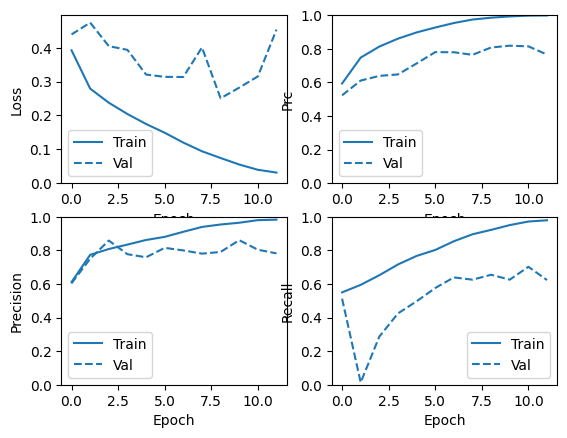

In [56]:
plot_metrics(history)

<Axes: xlabel='epochs'>

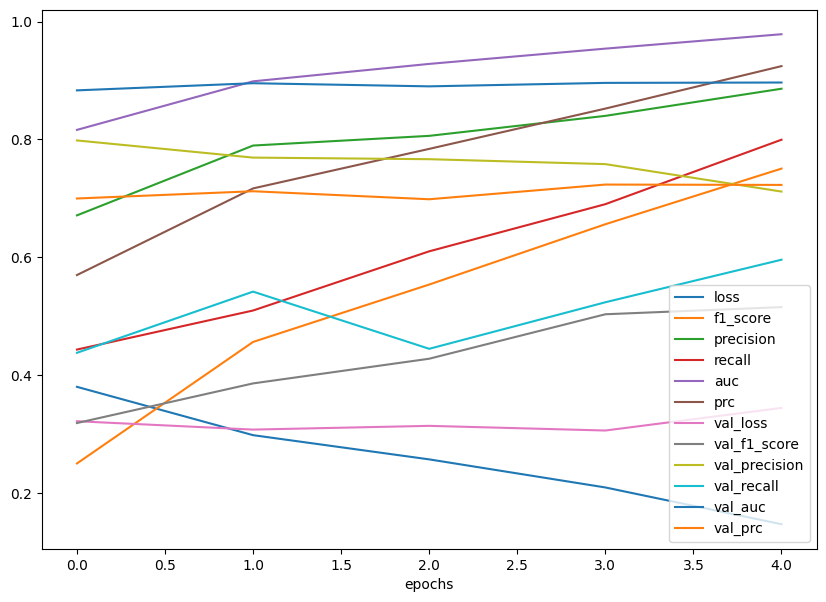

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7), xlabel="epochs")

Evaluation

In [59]:
simple_model1 = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/Simple_model/')

In [ ]:
simple_model1.evaluate(test_gen)

14/14 [==============================] - 15s 1s/step - loss: 0.3457 - f1_score: 0.5292 - precision: 0.7167 - recall: 0.6016 - auc: 0.9010 - prc: 0.7149


[0.34571537375450134,
 0.529183566570282,
 0.7167070508003235,
 0.6016260385513306,
 0.9009875059127808,
 0.7148895263671875]

Prediction

In [60]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=simple_model1.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 24s 2s/step


Confusion Matrix

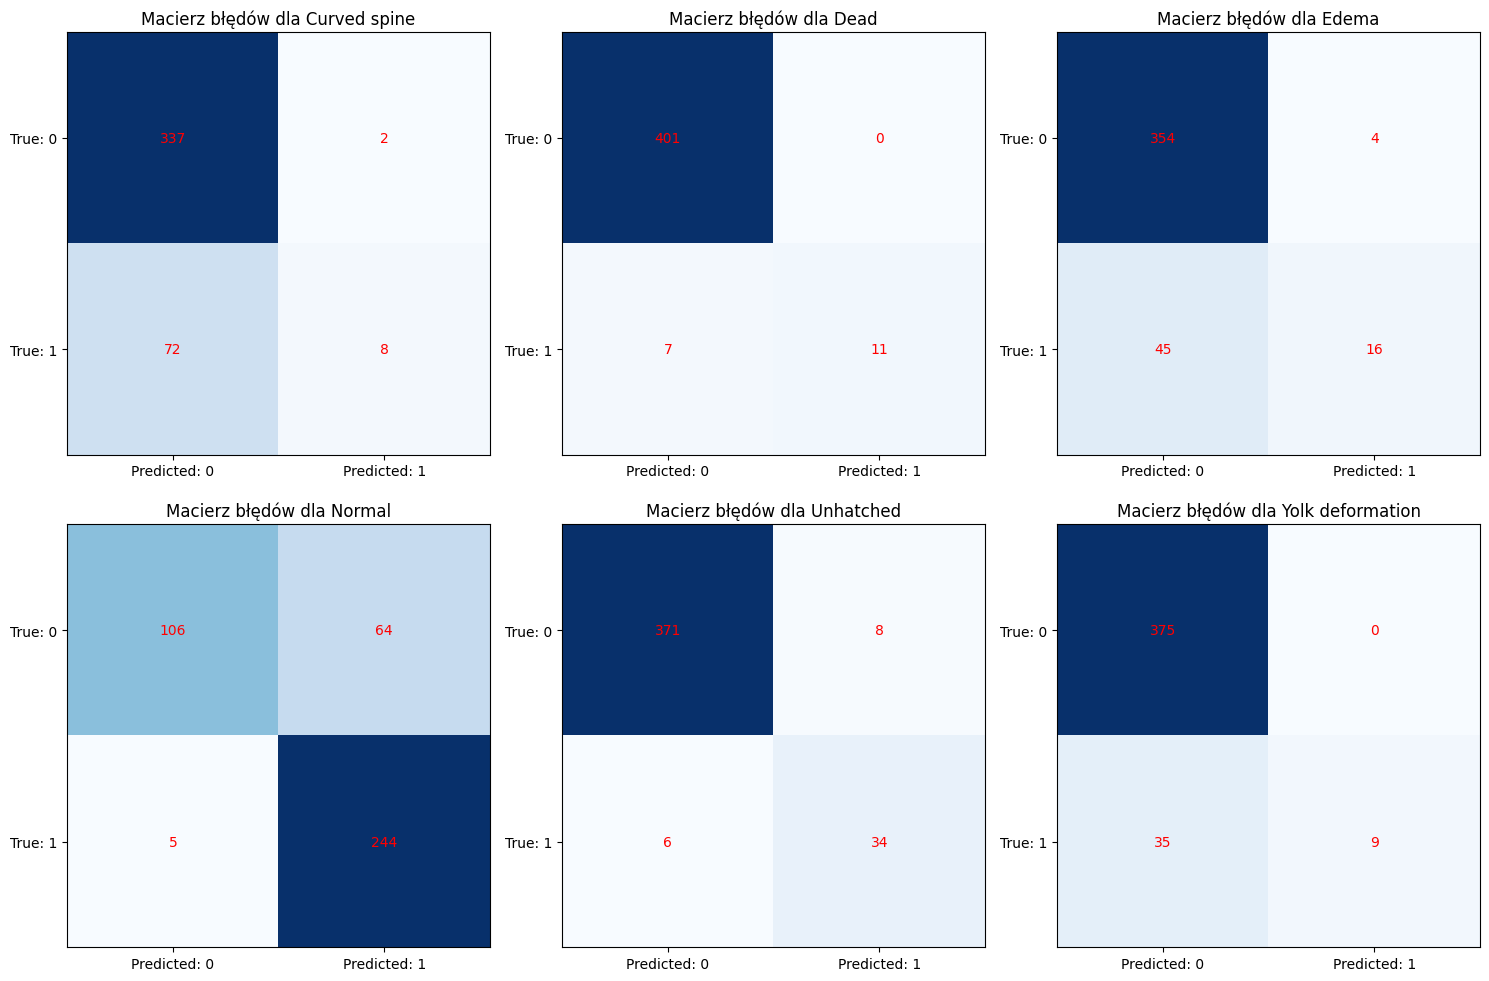

In [61]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

14/14 [==============================] - 28s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


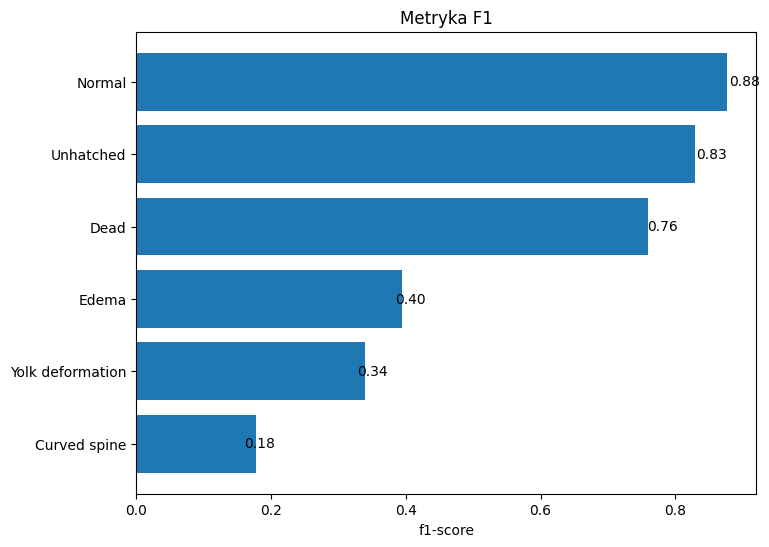

In [62]:
showF1scores(simple_model1,test_gen, class_names)

In [63]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.80      0.10      0.18        80
            Dead       1.00      0.61      0.76        18
           Edema       0.80      0.26      0.40        61
          Normal       0.79      0.98      0.88       249
       Unhatched       0.81      0.85      0.83        40
Yolk deformation       1.00      0.20      0.34        44

       micro avg       0.81      0.65      0.72       492
       macro avg       0.87      0.50      0.56       492
    weighted avg       0.82      0.65      0.65       492
     samples avg       0.73      0.72      0.72       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SimpleModel - class_weights


In [ ]:
run = wandb.init(project="SimpleModel_weighted")

In [41]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [42]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [45]:
simple_model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(384, 384, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(6, activation='sigmoid')
])


simple_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS2)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [46]:
history_1=simple_model.fit(
            train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks=[model_earlystop_callback,model_checkpoint_callback])

Epoch 1/15
106/106 [==============================] - ETA: 0s - loss: 0.5239 - f1_score: 0.1997 - precision: 0.2373 - recall: 0.2025 - auc: 0.5722 - prc: 0.2412
Epoch 1: val_loss improved from 0.53996 to 0.50915, saving model to drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint
106/106 [==============================] - 131s 1s/step - loss: 0.5239 - f1_score: 0.1997 - precision: 0.2373 - recall: 0.2025 - auc: 0.5722 - prc: 0.2412 - val_loss: 0.5092 - val_f1_score: 0.0261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6586 - val_prc: 0.2412
Epoch 2/15
106/106 [==============================] - ETA: 0s - loss: 0.3789 - f1_score: 0.3691 - precision: 0.4600 - recall: 0.2280 - auc: 0.7362 - prc: 0.4119
Epoch 2: val_loss did not improve from 0.50915
106/106 [==============================] - 135s 1s/step - loss: 0.3789 - f1_score: 0.3691 - precision: 0.4600 - recall: 0.2280 - auc: 0.7362 - prc: 0.4119 - val_loss: 0.5585 - val_f1_score: 0.1139 - val_precision: 0

In [ ]:
run.finish()

In [ ]:
simple_model.load_weights(checkpoint_filepath)

In [47]:
simple_model.save('drive/MyDrive/Colab Notebooks/Simple_model-weights/')

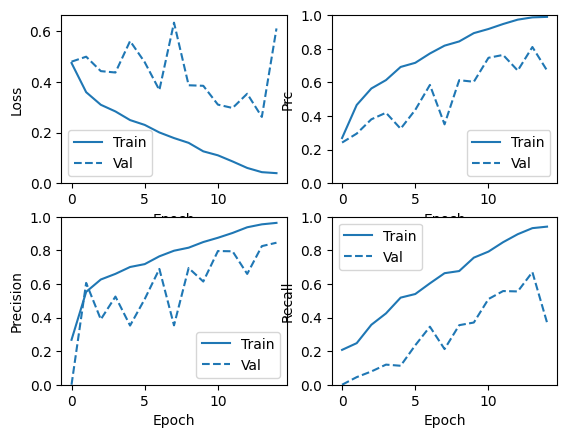

In [ ]:
plot_metrics(history_1)

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7), xlabel="epochs")

Evaluation

In [48]:
simple_model2 = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/Simple_model-weights/')

In [ ]:
simple_model2.evaluate(test_gen)

14/14 [==============================] - 16s 1s/step - loss: 0.3659 - f1_score: 0.5006 - precision: 0.6676 - recall: 0.4736 - auc: 0.8753 - prc: 0.6349


[0.3658945560455322,
 0.5006322264671326,
 0.6676217913627625,
 0.47357723116874695,
 0.8753482103347778,
 0.6349343061447144]

Prediction

In [49]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=simple_model2.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 28s 2s/step


Confusion Matrix

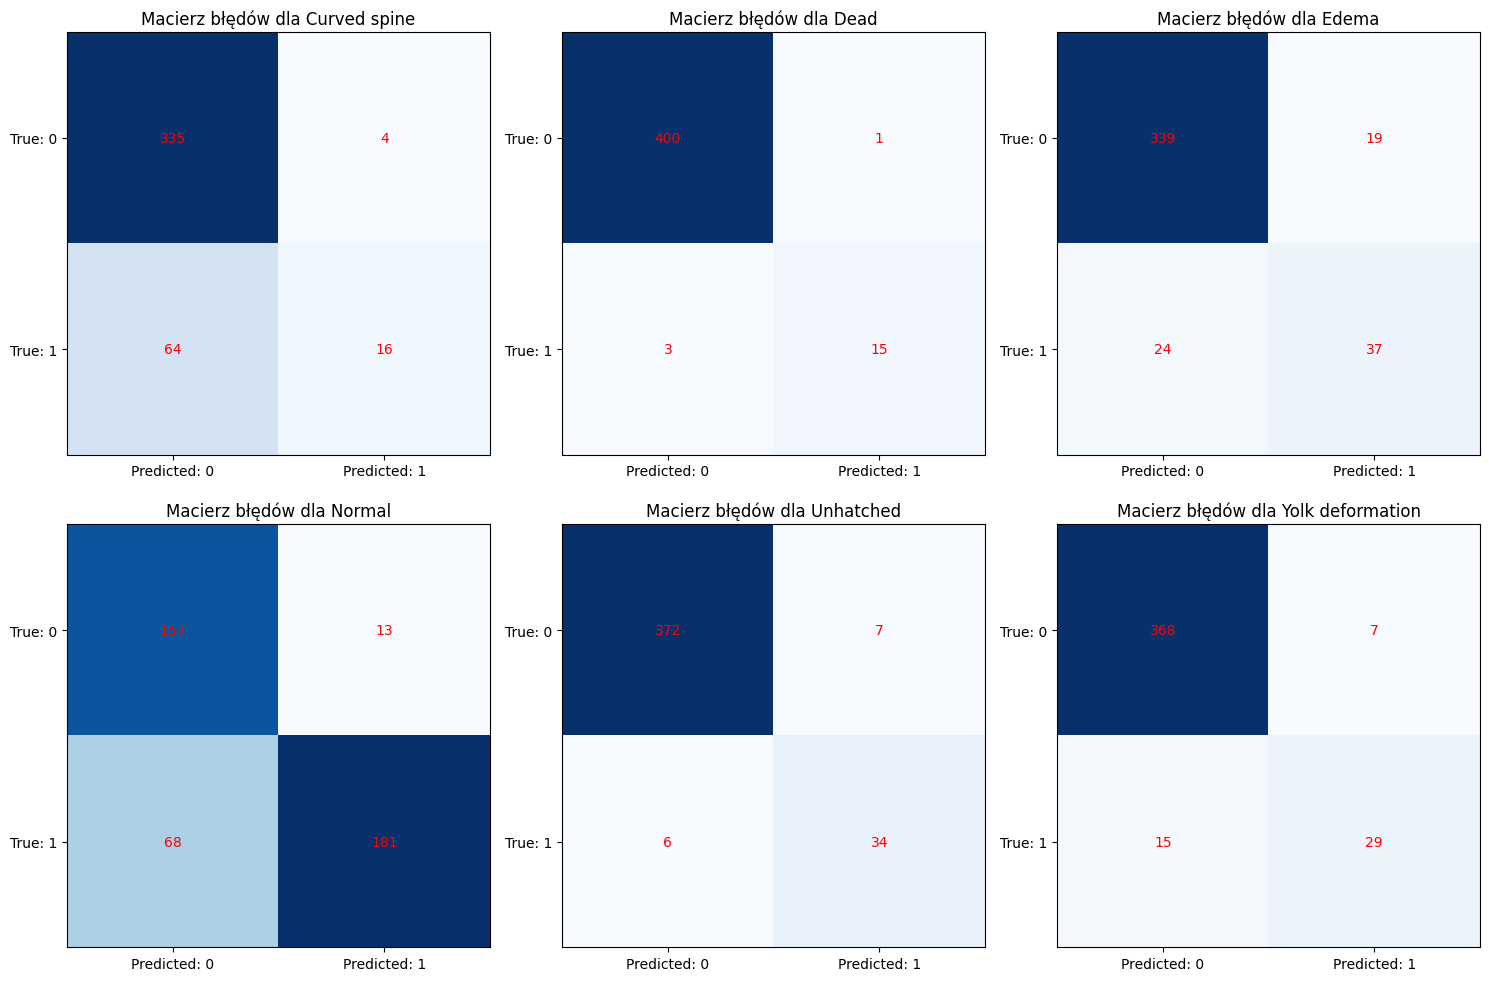

In [50]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

14/14 [==============================] - 16s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


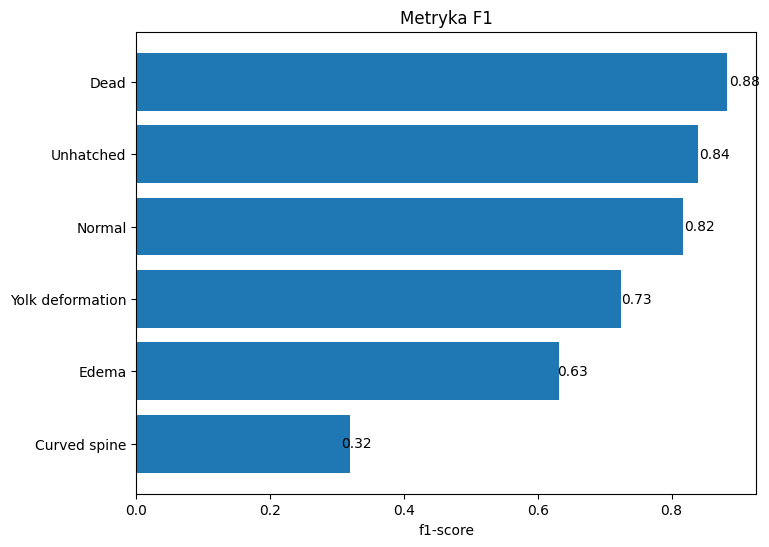

In [51]:
showF1scores(simple_model2,test_gen, class_names)

In [52]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.80      0.20      0.32        80
            Dead       0.94      0.83      0.88        18
           Edema       0.66      0.61      0.63        61
          Normal       0.93      0.73      0.82       249
       Unhatched       0.83      0.85      0.84        40
Yolk deformation       0.81      0.66      0.73        44

       micro avg       0.86      0.63      0.73       492
       macro avg       0.83      0.65      0.70       492
    weighted avg       0.86      0.63      0.71       492
     samples avg       0.66      0.65      0.65       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model - data augmentation, class_weights

In [ ]:
run = wandb.init(project="SimpleModel_weighted_augmented")

In [ ]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:
model_2 = Sequential([
    Conv2D(10,3,input_shape=(224, 224, 3)),
    Activation(activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(6, activation="sigmoid")
])


model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS2)

In [ ]:
history_2=model_2.fit(
            train_data_augmented,
            epochs=30,
            steps_per_epoch=len(train_data_augmented),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = [model_earlystop_callback, model_checkpoint_callback])

Epoch 1/10
106/106 [==============================] - 139s 1s/step - loss: 0.5167 - f1_score: 0.1063 - precision: 0.2463 - recall: 0.0570 - auc: 0.5088 - prc: 0.2055 - val_loss: 0.4845 - val_f1_score: 0.0900 - val_precision: 0.5000 - val_recall: 0.0203 - val_auc: 0.5965 - val_prc: 0.2392
Epoch 2/10
106/106 [==============================] - 139s 1s/step - loss: 0.4434 - f1_score: 0.1984 - precision: 0.4720 - recall: 0.0861 - auc: 0.6562 - prc: 0.3221 - val_loss: 0.4863 - val_f1_score: 0.1615 - val_precision: 0.1920 - val_recall: 0.0542 - val_auc: 0.6675 - val_prc: 0.2903
Epoch 3/10
106/106 [==============================] - 133s 1s/step - loss: 0.4192 - f1_score: 0.2821 - precision: 0.6104 - recall: 0.1293 - auc: 0.7030 - prc: 0.3954 - val_loss: 0.4256 - val_f1_score: 0.2807 - val_precision: 0.7051 - val_recall: 0.1242 - val_auc: 0.7439 - val_prc: 0.4340
Epoch 4/10
106/106 [==============================] - 134s 1s/step - loss: 0.4044 - f1_score: 0.2793 - precision: 0.6319 - recall: 0.

In [ ]:
run.finish()

In [ ]:
model_2.save('drive/MyDrive/Colab Notebooks/Model2_augm/')

In [ ]:
model2 = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/Model2_augm/')

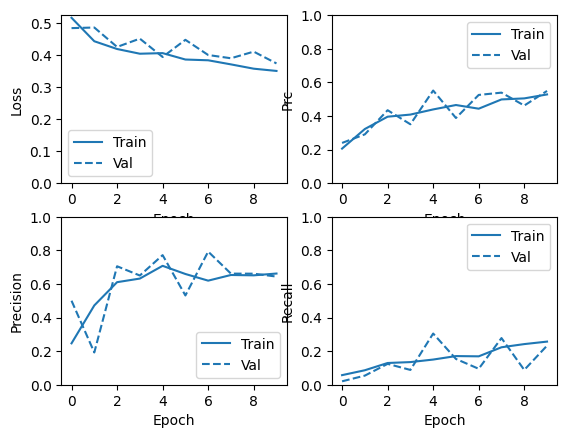

In [ ]:
plot_metrics(history_2)

Evaluation

Idealne Learning rate dla modelu

In [ ]:
lrs = 1e-4 * (10**(np.arange(10)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_1.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")

In [ ]:
model2_results = model_2.evaluate(test_gen)

14/14 [==============================] - 27s 2s/step - loss: 0.3636 - f1_score: 0.4801 - precision: 0.6364 - recall: 0.2134 - auc: 0.8452 - prc: 0.5597


In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model2.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 66s 5s/step


In [ ]:
results=pd.DataFrame(pred, columns=columns)
results["Filename"]=test_gen.filenames
ordered_cols=["Filename"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("results.csv",index=False)

1/1 [==============================] - 0s 492ms/step
Prediction: Curved spine 67.72%, True: 0
Prediction: Dead 1.90%, True: 0
Prediction: Edema 6.52%, True: 0
Prediction: Normal 45.14%, True: 1
Prediction: Unhatched 8.28%, True: 0
Prediction: Yolk deformation 12.88%, True: 0


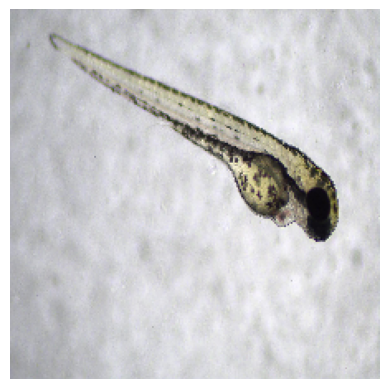

In [ ]:
random_number = random.randint(0, 31)

pred_and_plot(model=model_2, filename=test_images[random_number], true_label=test_gen.labels[random_number], class_names= class_names)

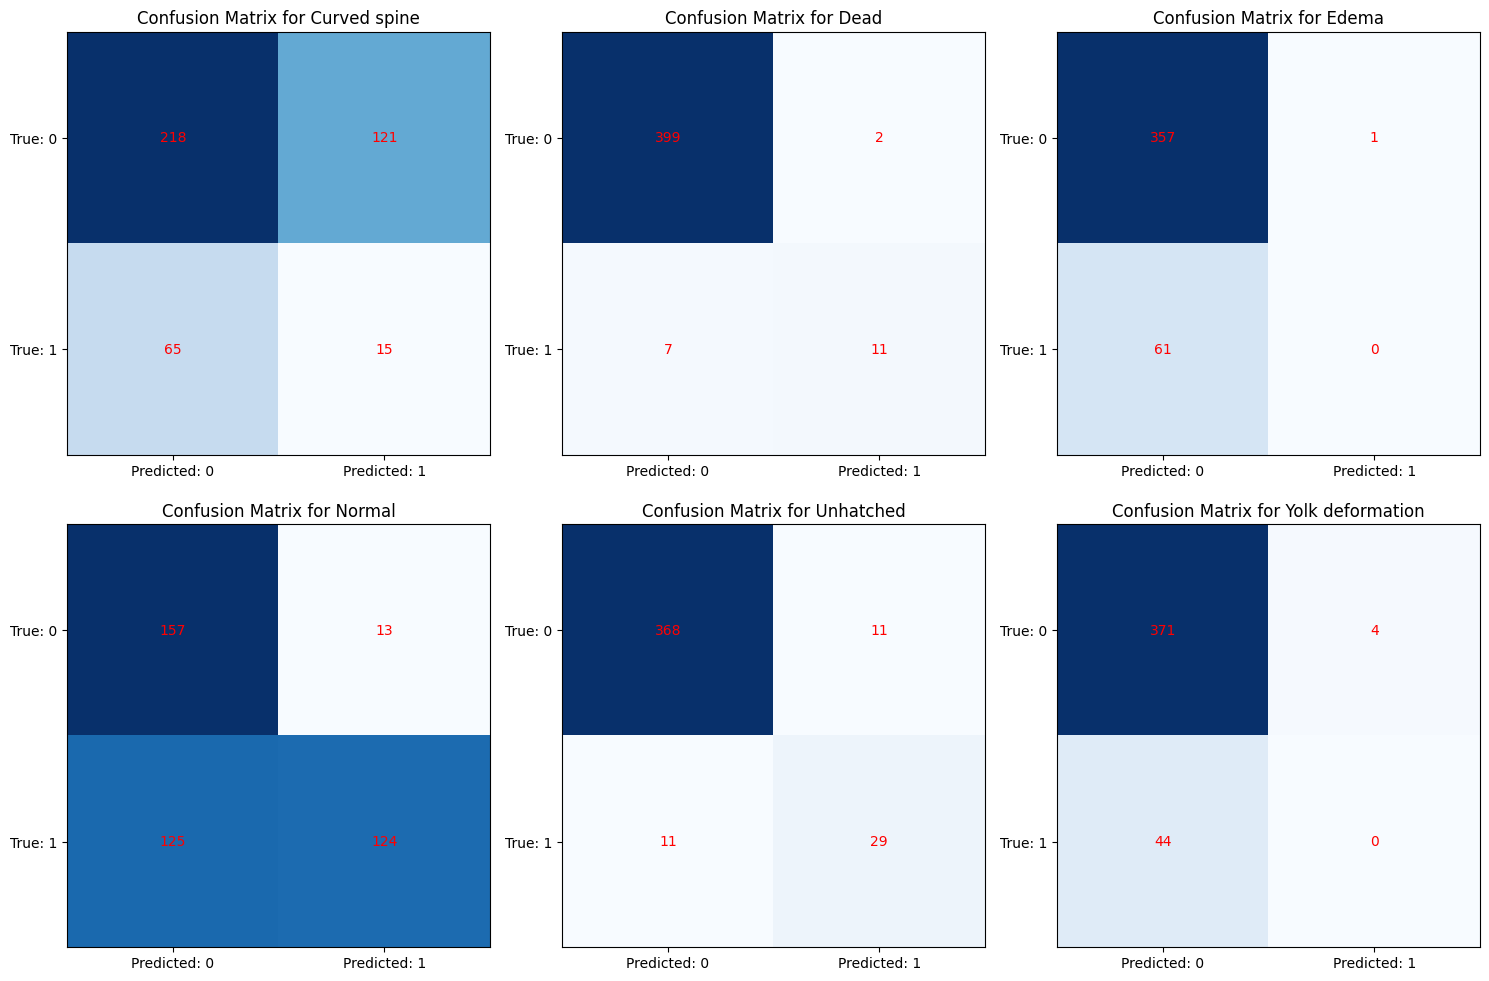

In [ ]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

Funkcja aktywacji softmax nie sprawdzi się w przypadku multilabel, lepsze wyniki da sigmoid która każdą klasę rozpatruje w zakresie 0-1.

14/14 [==============================] - 8s 524ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


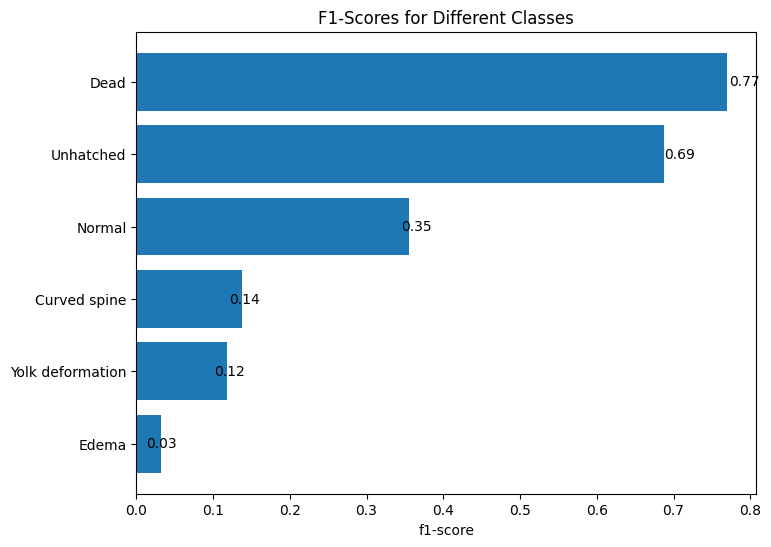

In [ ]:
showF1scores(model_2,test_gen, class_names)

In [ ]:
run = wandb.init(project="SimpleModel_weighted_augmented")

In [ ]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:


model_3 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(6, activation='sigmoid')  # Assuming 6 classes with multi-label classification
])

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS2)

In [ ]:
history_3=model_3.fit(
            train_data_augmented,
            epochs=30,
            steps_per_epoch=len(train_data_augmented),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])

Epoch 1/30
106/106 [==============================] - 143s 1s/step - loss: 0.5253 - f1_score: 0.2551 - precision: 0.3220 - recall: 0.2177 - auc: 0.6026 - prc: 0.2986 - val_loss: 0.5194 - val_f1_score: 0.0261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6355 - val_prc: 0.2369 - lr: 0.0010
Epoch 2/30
106/106 [==============================] - 141s 1s/step - loss: 0.4094 - f1_score: 0.3479 - precision: 0.4438 - recall: 0.2081 - auc: 0.7146 - prc: 0.3769 - val_loss: 0.6358 - val_f1_score: 0.0261 - val_precision: 0.2222 - val_recall: 0.0542 - val_auc: 0.4993 - val_prc: 0.1956 - lr: 0.0010
Epoch 3/30
106/106 [==============================] - 142s 1s/step - loss: 0.3839 - f1_score: 0.3900 - precision: 0.5372 - recall: 0.2549 - auc: 0.7600 - prc: 0.4475 - val_loss: 0.7005 - val_f1_score: 0.0316 - val_precision: 0.0966 - val_recall: 0.0700 - val_auc: 0.5355 - val_prc: 0.2166 - lr: 0.0010
Epoch 4/30
106/106 [==============================] - 138s 1s/step - loss: 0.3617 - f1

In [ ]:
run.finish()

In [ ]:
model_3.save('drive/MyDrive/Colab Notebooks/Model3_augm/')

In [ ]:
model3 = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/Model3_augm/')

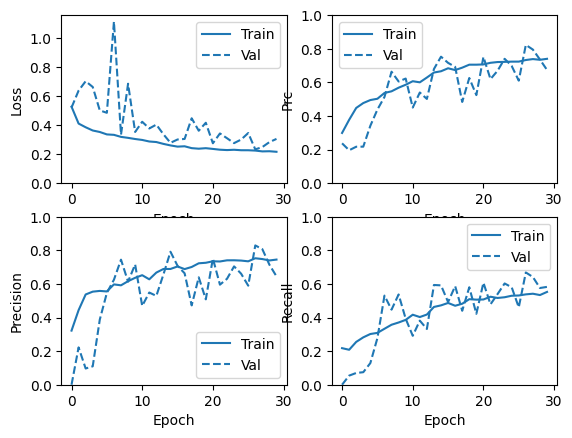

In [ ]:
plot_metrics(history_3)

Evaluation

Idealne Learning rate dla modelu

In [ ]:
model3_results = model3.evaluate(test_gen)

14/14 [==============================] - 16s 1s/step - loss: 0.2812 - f1_score: 0.5720 - precision: 0.6856 - recall: 0.6382 - auc: 0.9178 - prc: 0.7220


In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model3.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 71s 5s/step


1/1 [==============================] - 1s 886ms/step
Prediction: Curved spine 9.01%, True: 0
Prediction: Dead 0.03%, True: 0
Prediction: Edema 58.74%, True: 0
Prediction: Normal 55.37%, True: 1
Prediction: Unhatched 0.24%, True: 0
Prediction: Yolk deformation 2.78%, True: 0


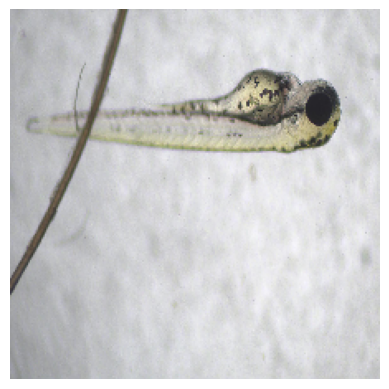

In [ ]:
random_number = random.randint(0, 31)

pred_and_plot(model=model3, filename=test_images[random_number], true_label=test_gen.labels[random_number], class_names= class_names)

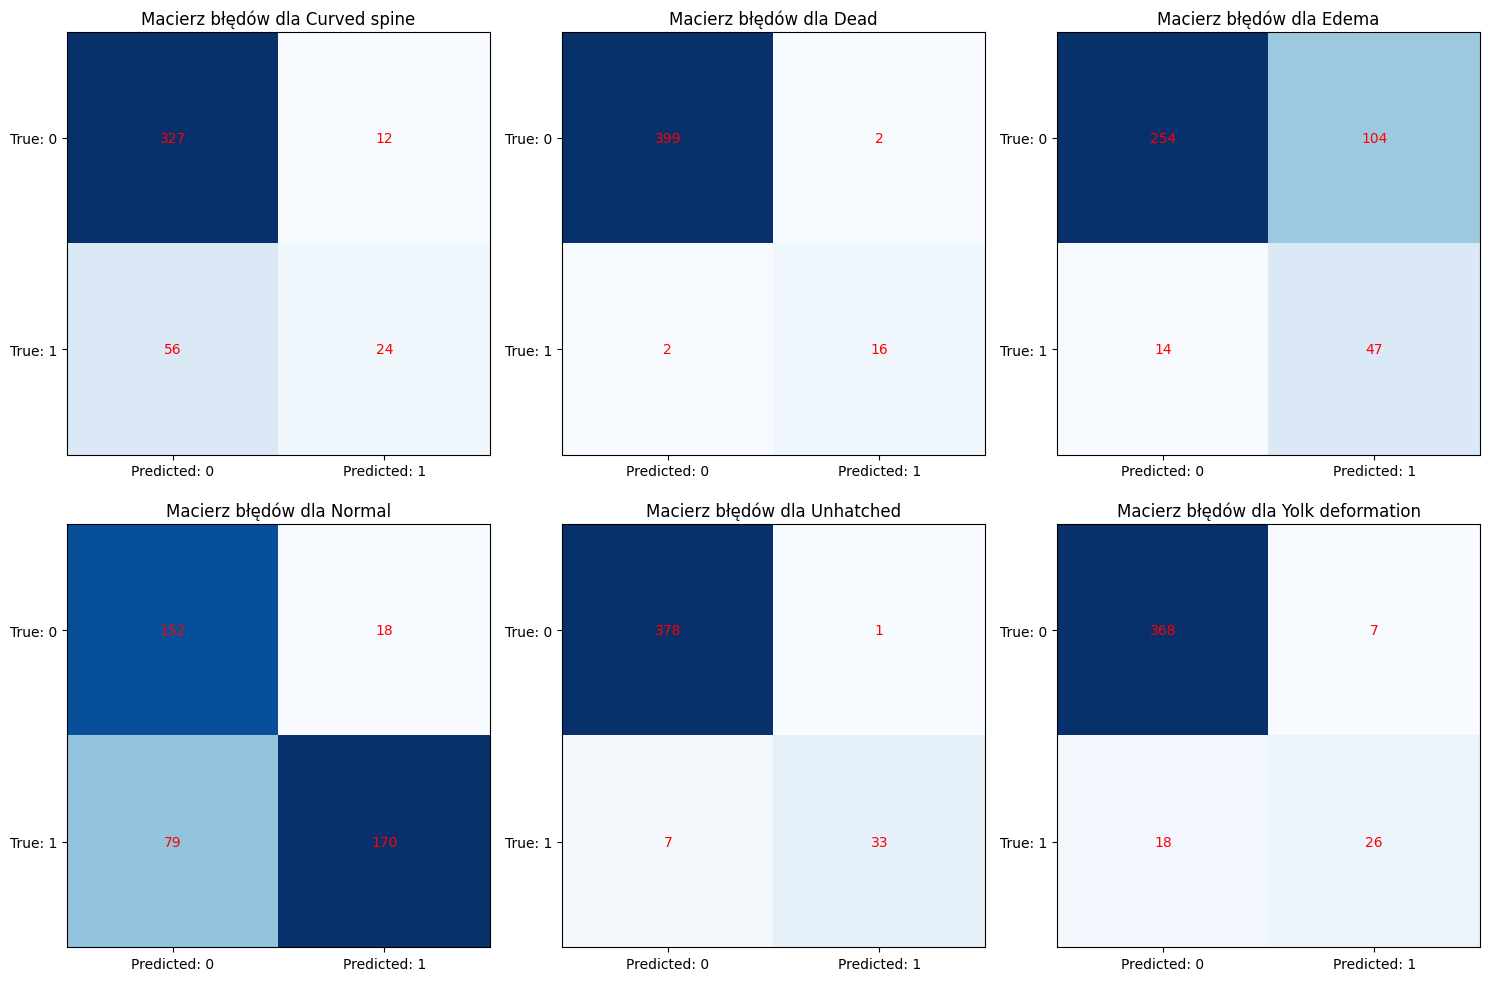

In [ ]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

Funkcja aktywacji softmax nie sprawdzi się w przypadku multilabel, lepsze wyniki da sigmoid która każdą klasę rozpatruje w zakresie 0-1.

14/14 [==============================] - 71s 5s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


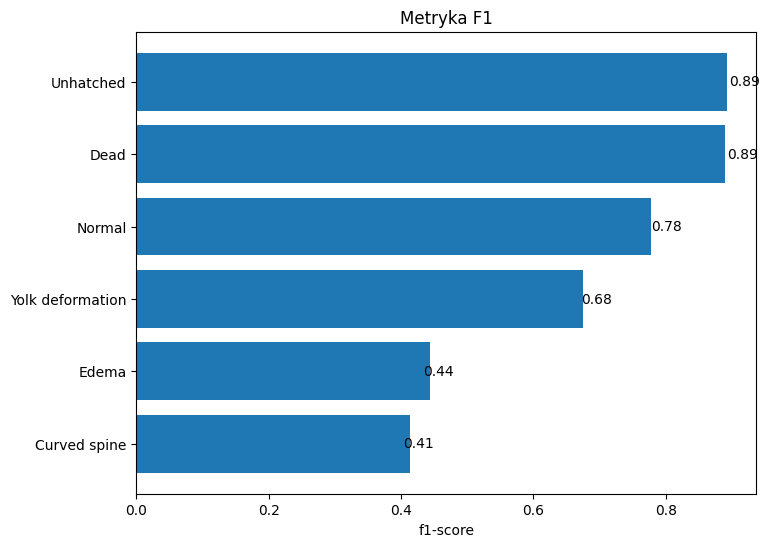

In [ ]:
showF1scores(model3,test_gen, class_names)

In [ ]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.67      0.30      0.41        80
            Dead       0.89      0.89      0.89        18
           Edema       0.31      0.77      0.44        61
          Normal       0.90      0.68      0.78       249
       Unhatched       0.97      0.82      0.89        40
Yolk deformation       0.79      0.59      0.68        44

       micro avg       0.69      0.64      0.66       492
       macro avg       0.75      0.68      0.68       492
    weighted avg       0.79      0.64      0.68       492
     samples avg       0.61      0.64      0.62       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Transfer-Learning ResNet

In [70]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [71]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
], name="data_augmentation")

def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    model = keras.applications.ResNet50V2(include_top=False, input_tensor=x, weights="imagenet", classes=num_classes)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation="relu")(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="ResNet50V2")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2
    )
    return model

model = build_model(num_classes=6)
resnet_history = model.fit(train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks=model_earlystop_callback)

Epoch 1/15
106/106 [==============================] - 150s 1s/step - loss: 0.3185 - f1_score: 0.6287 - precision: 0.6967 - recall: 0.6721 - auc: 0.9158 - prc: 0.7672 - val_loss: 0.2227 - val_f1_score: 0.6960 - val_precision: 0.8125 - val_recall: 0.6749 - val_auc: 0.9489 - val_prc: 0.8344
Epoch 2/15
106/106 [==============================] - 133s 1s/step - loss: 0.1941 - f1_score: 0.7296 - precision: 0.8035 - recall: 0.7661 - auc: 0.9579 - prc: 0.8653 - val_loss: 0.1719 - val_f1_score: 0.7551 - val_precision: 0.8625 - val_recall: 0.7788 - val_auc: 0.9671 - val_prc: 0.9083
Epoch 3/15
106/106 [==============================] - 136s 1s/step - loss: 0.1665 - f1_score: 0.7318 - precision: 0.8146 - recall: 0.7648 - auc: 0.9604 - prc: 0.8813 - val_loss: 0.1464 - val_f1_score: 0.7520 - val_precision: 0.8670 - val_recall: 0.8239 - val_auc: 0.9786 - val_prc: 0.9235
Epoch 4/15
106/106 [==============================] - 130s 1s/step - loss: 0.1505 - f1_score: 0.7485 - precision: 0.8384 - recall: 0.

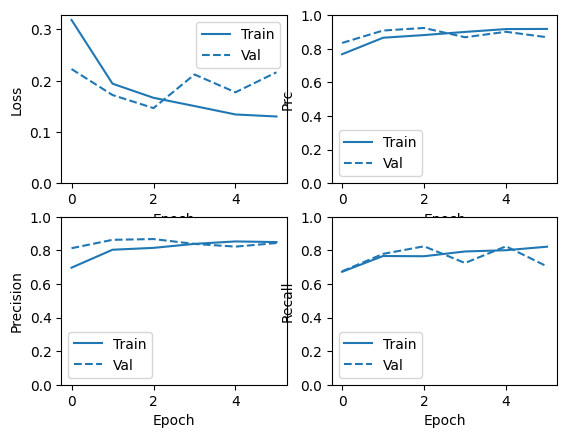

In [72]:
plot_metrics(resnet_history)

14/14 [==============================] - 27s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


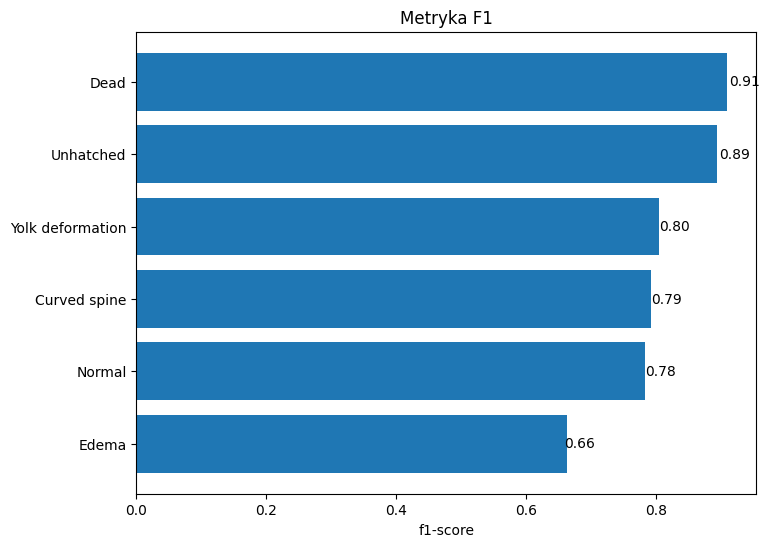

In [73]:
showF1scores(model, test_gen, class_names)

In [78]:
model.save('drive/MyDrive/Colab Notebooks/ResNet_BestSoFar/')

In [74]:
test_gen.reset()

14/14 [==============================] - 18s 1s/step


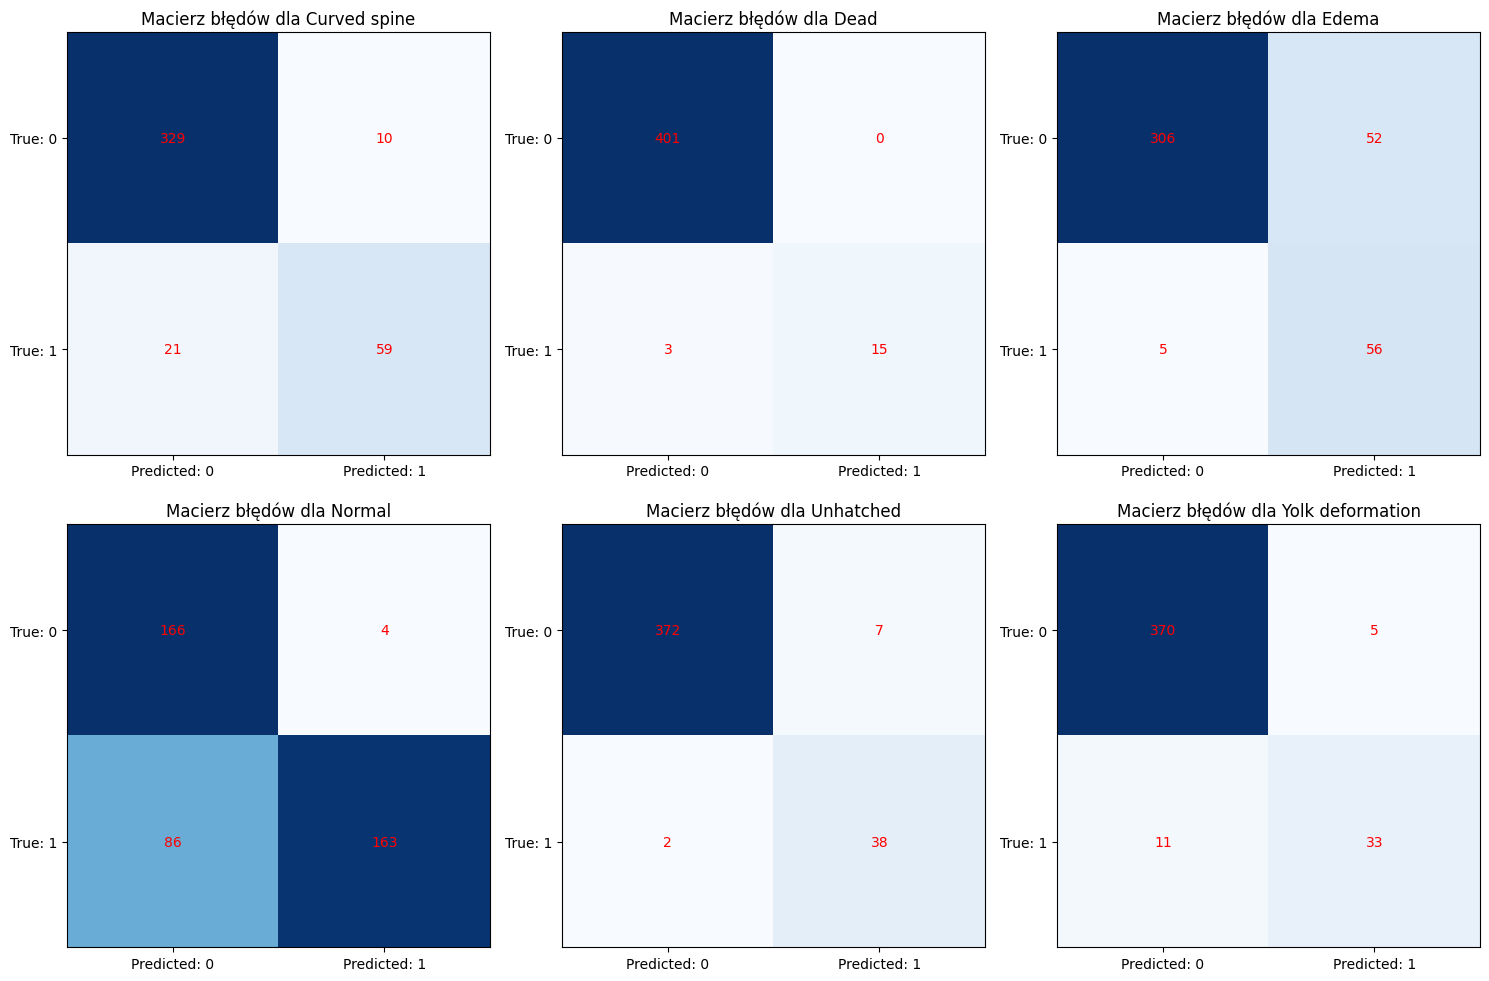

In [75]:
pred=model.predict(test_gen,
steps=len(test_gen),
verbose=1)
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

In [76]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.86      0.74      0.79        80
            Dead       1.00      0.83      0.91        18
           Edema       0.52      0.92      0.66        61
          Normal       0.98      0.65      0.78       249
       Unhatched       0.84      0.95      0.89        40
Yolk deformation       0.87      0.75      0.80        44

       micro avg       0.82      0.74      0.78       492
       macro avg       0.84      0.81      0.81       492
    weighted avg       0.88      0.74      0.79       492
     samples avg       0.71      0.73      0.71       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fine-tuning ResNet

In [ ]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
], name="data_augmentation")


inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
base_model = keras.applications.ResNet50V2(include_top=False, input_tensor=x, weights="imagenet", classes=6)

    # Freeze the pretrained weights
for layer in base_model.layers[:]:
  layer.trainable = False

    # Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu")(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="sigmoid", name="pred")(x)

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2
)

resnet_history = model.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = model_earlystop_callback)


94668760/94668760 [==============================] - 2s 0us/step
Epoch 1/10
106/106 [==============================] - 125s 1s/step - loss: 0.2988 - f1_score: 0.5854 - precision: 0.6931 - recall: 0.6292 - auc: 0.9000 - prc: 0.7468 - val_loss: 0.2288 - val_f1_score: 0.6627 - val_precision: 0.7129 - val_recall: 0.8352 - val_auc: 0.9595 - val_prc: 0.8657
Epoch 2/10
106/106 [==============================] - 110s 1s/step - loss: 0.1971 - f1_score: 0.7068 - precision: 0.7987 - recall: 0.7526 - auc: 0.9531 - prc: 0.8554 - val_loss: 0.2023 - val_f1_score: 0.6609 - val_precision: 0.7761 - val_recall: 0.8059 - val_auc: 0.9621 - val_prc: 0.8732
Epoch 3/10
106/106 [==============================] - 99s 934ms/step - loss: 0.1706 - f1_score: 0.7023 - precision: 0.8126 - recall: 0.7658 - auc: 0.9592 - prc: 0.8754 - val_loss: 0.1748 - val_f1_score: 0.7054 - val_precision: 0.8526 - val_recall: 0.7833 - val_auc: 0.9698 - val_prc: 0.8984
Epoch 4/10
106/106 [==============================] - 106s 1s/step

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 data_augmentation False
2 conv1_pad False
3 conv1_conv False
4 pool1_pad False
5 pool1_pool False
6 conv2_block1_preact_bn False
7 conv2_block1_preact_relu False
8 conv2_block1_1_conv False
9 conv2_block1_1_bn False
10 conv2_block1_1_relu False
11 conv2_block1_2_pad False
12 conv2_block1_2_conv False
13 conv2_block1_2_bn False
14 conv2_block1_2_relu False
15 conv2_block1_0_conv False
16 conv2_block1_3_conv False
17 conv2_block1_out False
18 conv2_block2_preact_bn False
19 conv2_block2_preact_relu False
20 conv2_block2_1_conv False
21 conv2_block2_1_bn False
22 conv2_block2_1_relu False
23 conv2_block2_2_pad False
24 conv2_block2_2_conv False
25 conv2_block2_2_bn False
26 conv2_block2_2_relu False
27 conv2_block2_3_conv False
28 conv2_block2_out False
29 conv2_block3_preact_bn False
30 conv2_block3_preact_relu False
31 conv2_block3_1_conv False
32 conv2_block3_1_bn False
33 conv2_block3_1_relu False
34 conv2_block3_2_pad False
35 conv2_block3_2_conv False
36 conv2_bloc

In [ ]:
for layer in base_model.layers[:178]:
   layer.trainable = False
for layer in base_model.layers[178:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 data_augmentation False
2 conv1_pad False
3 conv1_conv False
4 pool1_pad False
5 pool1_pool False
6 conv2_block1_preact_bn False
7 conv2_block1_preact_relu False
8 conv2_block1_1_conv False
9 conv2_block1_1_bn False
10 conv2_block1_1_relu False
11 conv2_block1_2_pad False
12 conv2_block1_2_conv False
13 conv2_block1_2_bn False
14 conv2_block1_2_relu False
15 conv2_block1_0_conv False
16 conv2_block1_3_conv False
17 conv2_block1_out False
18 conv2_block2_preact_bn False
19 conv2_block2_preact_relu False
20 conv2_block2_1_conv False
21 conv2_block2_1_bn False
22 conv2_block2_1_relu False
23 conv2_block2_2_pad False
24 conv2_block2_2_conv False
25 conv2_block2_2_bn False
26 conv2_block2_2_relu False
27 conv2_block2_3_conv False
28 conv2_block2_out False
29 conv2_block3_preact_bn False
30 conv2_block3_preact_relu False
31 conv2_block3_1_conv False
32 conv2_block3_1_bn False
33 conv2_block3_1_relu False
34 conv2_block3_2_pad False
35 conv2_block3_2_conv False
36 conv2_bloc

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2)

resnet_history_FT = model.fit(
            train_data,
            epochs=30,
            initial_epoch=resnet_history.epoch[-1],
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = model_earlystop_callback)

Epoch 9/30
106/106 [==============================] - 112s 944ms/step - loss: 0.1241 - f1_score: 0.7444 - precision: 0.8575 - recall: 0.8372 - auc: 0.9766 - prc: 0.9229 - val_loss: 0.2012 - val_f1_score: 0.7392 - val_precision: 0.8575 - val_recall: 0.8555 - val_auc: 0.9671 - val_prc: 0.9043
Epoch 10/30
106/106 [==============================] - 103s 972ms/step - loss: 0.1006 - f1_score: 0.7647 - precision: 0.8726 - recall: 0.8285 - auc: 0.9809 - prc: 0.9337 - val_loss: 0.1433 - val_f1_score: 0.7490 - val_precision: 0.8629 - val_recall: 0.8668 - val_auc: 0.9797 - val_prc: 0.9403
Epoch 11/30
106/106 [==============================] - 103s 976ms/step - loss: 0.1058 - f1_score: 0.7600 - precision: 0.8727 - recall: 0.8252 - auc: 0.9810 - prc: 0.9311 - val_loss: 0.1687 - val_f1_score: 0.7381 - val_precision: 0.8460 - val_recall: 0.8307 - val_auc: 0.9735 - val_prc: 0.9145
Epoch 12/30
106/106 [==============================] - 102s 963ms/step - loss: 0.0871 - f1_score: 0.7912 - precision: 0.88

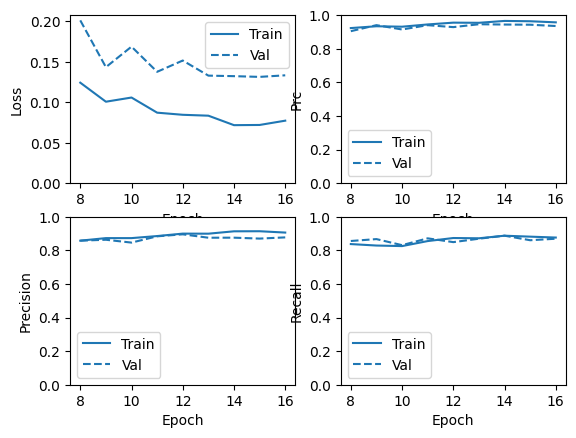

In [ ]:
plot_metrics(resnet_history_FT)

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/ResNet_FT_BestSoFar/')

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/ResNet_FT_BestSoFar.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
resnet_FT = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/ResNet_FT_BestSoFar.h5', compile=False)

In [ ]:
resnet_FT.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, None, None, None)     0         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['data_augmentation[0][0]']   
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']

14/14 [==============================] - 115s 8s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


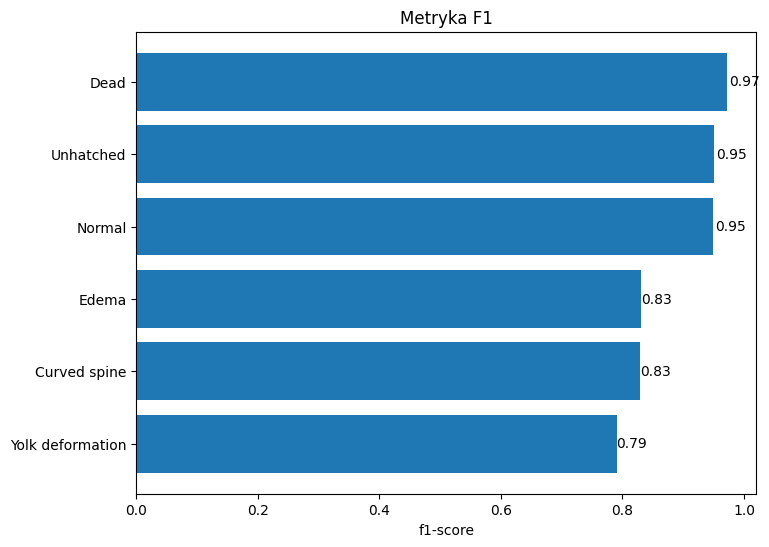

In [ ]:
showF1scores(resnet_FT, test_gen, class_names)

In [ ]:
resnet_FT.evaluate(test_gen)

14/14 [==============================] - 16s 1s/step - loss: 0.1095 - f1_score: 0.7917 - precision: 0.8956 - recall: 0.9065 - auc: 0.9863 - prc: 0.9587


[0.1095394566655159,
 0.7916970252990723,
 0.8955823183059692,
 0.9065040946006775,
 0.9862821102142334,
 0.958713173866272]

In [ ]:
pred=resnet_FT.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 119s 8s/step


In [ ]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.88      0.79      0.83        80
            Dead       1.00      0.94      0.97        18
           Edema       0.78      0.89      0.83        61
          Normal       0.96      0.94      0.95       249
       Unhatched       0.93      0.97      0.95        40
Yolk deformation       0.73      0.86      0.79        44

       micro avg       0.90      0.91      0.90       492
       macro avg       0.88      0.90      0.89       492
    weighted avg       0.90      0.91      0.90       492
     samples avg       0.89      0.91      0.89       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 2s 2s/step
Prediction: Curved spine 0.03%, True: 0
Prediction: Dead 0.02%, True: 0
Prediction: Edema 24.63%, True: 0
Prediction: Normal 0.02%, True: 0
Prediction: Unhatched 100.00%, True: 1
Prediction: Yolk deformation 2.98%, True: 0


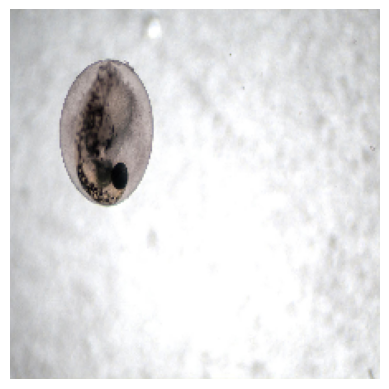

In [ ]:
random_number = random.randint(0, 31)
pred_and_plot(model=resnet_FT, filename=test_images[9], true_label=test_gen.labels[9], class_names= class_names)

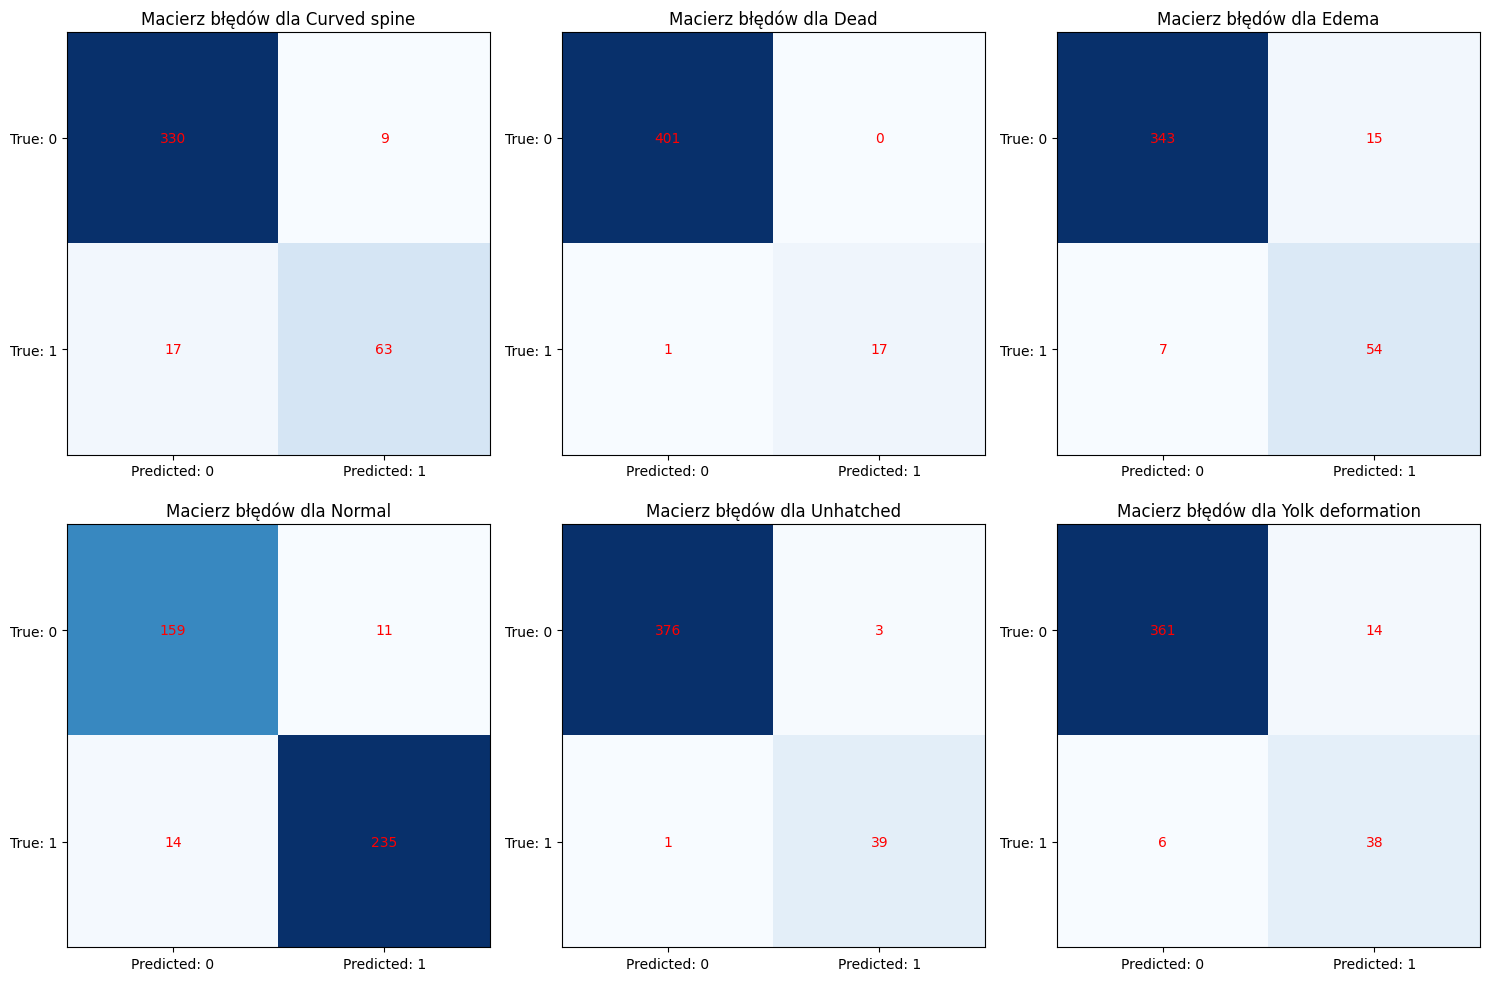

In [ ]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

#Heatmap

In [ ]:
import numpy as np
import tensorflow as tf
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np
from keras.preprocessing import image
import keras.backend as K
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image as pil_image

def get_dim_scale(scale_percent = 50, img = None):
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  return dim

def gradCAM(image_source, img_scale_dim_factor, model, intensity=0.5):

  img = io.imread(image_source)
  dim = get_dim_scale(img_scale_dim_factor, img)
  # resize image
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  img_x = cv2.resize(img, (224, 224))
  x = image.img_to_array(img_x)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv5_block3_out')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img_heatmap = heatmap * intensity + img

  # Original image vs. image plus heatmap
  cv2_imshow(img)
  cv2_imshow(img_heatmap)

gradCAM('drive/MyDrive/test2/10.jpg', 15, resnet_FT)

1/1 [==============================] - 0s 37ms/step


ValueError: cannot reshape array of size 49 into shape (8,8)

In [ ]:
import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model_builder = keras.applications.resnet50
img_size = (224, 224)
preprocess_input = keras.applications.resnet50
decode_predictions = keras.applications.resnet50

last_conv_layer_name = "conv5_block3_out"

In [ ]:
img_path = "drive/MyDrive/test2/20.jpg"
target_size = (224,224)
image = Image.open(img_path).convert('RGB')

image = ImageOps.fit(image, target_size, Image.Resampling.LANCZOS)
# Convert image to numpy array
image_array = np.asarray(image)
# Normalize image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
# Set model input
data = np.ndarray(shape=(1, *target_size, 3), dtype=np.float32)
data[0] = normalized_image_array
preds = resnet_FT.predict(data)

1/1 [==============================] - 0s 42ms/step


In [ ]:
def display_predictions(pred, model_name):
    pred = np.array(pred)
    sorted_indices = np.argsort(pred[0])[::-1]  # Sort indices in descending order based on pred[0]
    sorted_class_names = [class_names[i] for i in sorted_indices]
    sorted_pred = [pred[0][i] for i in sorted_indices]

    for class_name, prediction in zip(sorted_class_names, sorted_pred):
        if prediction > 0.5:
            print(f"{class_name}")
            print(f"{prediction * 100:.2f}%")

In [ ]:
display_predictions(preds, "ResNet")

Normal
100.00%


In [ ]:
class_names = ["Curved spine", "Dead", "Edema", "Normal", "Unhatched", "Yolk deformation"]

1/1 [==============================] - 0s 77ms/step
Predicted Labels: [[0 0 0 0 0 0]]


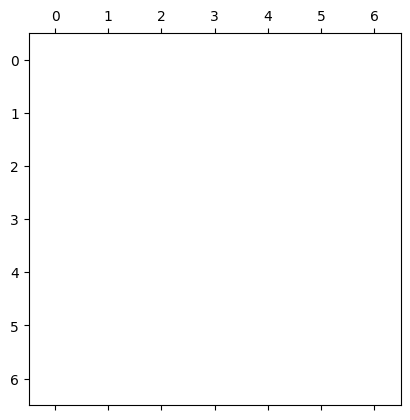

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow import keras
from keras.models import load_model

def get_img_array(img_path, size):
    # `img` is a PIL image of the specified size
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (size[0], size[1], 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, size[0], size[1], 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()




1/1 [==============================] - 0s 24ms/step
Predicted Labels: tf.Tensor(3, shape=(), dtype=int64)


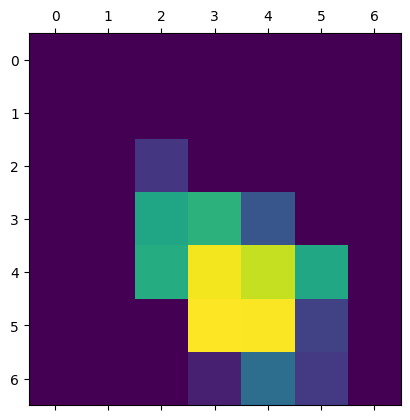

In [ ]:
# Define image size
img_size = (224, 224)

# Load model
model = resnet_FT

# Remove the last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(data)
#preds = np.array(preds)
preds = model.predict(data)
preds = np.array(preds)

# Convert predictions to multi-label format with threshold (e.g., 0.5)
threshold = 0.5
preds = (preds > threshold).astype(int)
print("Predicted Labels:", tf.argmax(preds[0]))

# Generate class activation heatmap
last_conv_layer_name = "conv5_block3_out"  # Change to the correct layer name if different
heatmap = make_gradcam_heatmap(data, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

1/1 [==============================] - 0s 110ms/step
Predicted Labels: tf.Tensor(0, shape=(), dtype=int64)


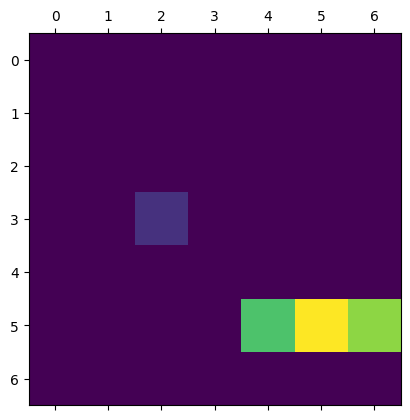

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow import keras
from keras.models import load_model

img_path = "drive/MyDrive/test2/27.jpg"
target_size = (224,224)
image = Image.open(img_path).convert('RGB')

image = ImageOps.fit(image, target_size, Image.Resampling.LANCZOS)
# Convert image to numpy array
image_array = np.asarray(image)
# Normalize image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
# Set model input
data = np.ndarray(shape=(1, *target_size, 3), dtype=np.float32)
data[0] = normalized_image_array
preds = resnet_FT.predict(data)

def get_img_array(img_path, size):
    # `img` is a PIL image of the specified size
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (size[0], size[1], 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, size[0], size[1], 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Define image size
img_size = (224, 224)

# Load model
model = resnet_FT

# Remove the last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(data)
#preds = np.array(preds)
preds = model.predict(data)
preds = np.array(preds)

# Convert predictions to multi-label format with threshold (e.g., 0.5)
threshold = 0.5
preds = (preds > threshold).astype(int)
print("Predicted Labels:", tf.argmax(preds[0]))

# Generate class activation heatmap
last_conv_layer_name = "conv5_block3_out"  # Change to the correct layer name if different
heatmap = make_gradcam_heatmap(data, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

def display_gradcam(img_path, heatmap, alpha=0.3):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)


display_gradcam(img_path, heatmap)

In [ ]:
import numpy as np
import tensorflow as tf
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps

def grad_cam(fname, model):
    # Load the image
    img = Image.open(fname).convert('RGB')
    img_array_original = np.asarray(img)

    # Resize the image while maintaining aspect ratio
    desired_size = (224, 224)
    img = ImageOps.fit(img, desired_size, Image.LANCZOS)
    img_array_resized = np.asarray(img)

    # Preprocess the resized image
    img_array_resized = preprocess_input(np.expand_dims(img_array_resized, axis=0))

    # Get model predictions
    preds = model.predict(img_array_resized)

    # Retrieve the predicted classes with probabilities > 0.5
    pred_classes = np.argwhere(preds > 0.5)[:, 1]

    if len(pred_classes) == 0:
        print("No predicted classes with probabilities greater than 0.5.")
        return

    # Get gradients and compute heatmap
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out')
        iterate = tf.keras.models.Model([model.input], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img_array_resized)

        heatmaps = []

        for class_index in pred_classes:
            class_out = model_out[:, class_index]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            heatmap /= tf.reduce_max(heatmap)
            heatmaps.append(heatmap.numpy())

    # Combine heatmaps
    heatmap_combined = np.mean(heatmaps, axis=0)

    # Resize the heatmap to match the dimensions of the original image
    heatmap_resized = cv2.resize(heatmap_combined, (img_array_original.shape[1], img_array_original.shape[0]))

    # Convert heatmap to colored overlay
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = plt.get_cmap('jet')(heatmap_uint8)[:, :, :3]  # Remove the alpha channel
    heatmap_jet_resized = cv2.resize(heatmap_jet, (img_array_original.shape[1], img_array_original.shape[0]))

    # Overlay the heatmap on the original image
    superimposed_img = heatmap_jet_resized * 0.4 + img_array_original  # Adjust the overlay intensity (0.4)
    superimposed_img = Image.fromarray(np.uint8(superimposed_img))

    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Usage example
fname = "data_one_hot/images/0,5-002.jpg"
grad_cam(fname, resnet_FT)


1/1 [==============================] - 6s 6s/step


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:3940: error: (-215:Assertion failed) func != 0 in function 'resize'


In [ ]:
import cv2

In [ ]:
import tensorflow as tf
from skimage import data, color, io, img_as_float
def get_heatmap(processed_image, model, last_conv_layer, class_idx):
    # We want the activations for the predicted label
    class_output = model.output[:, class_idx]

    # Choose the last conv layer in your model
    last_conv_layer = model.get_layer(last_conv_layer)

    # Start recording the gradient tape
    with tf.GradientTape() as tape:
        # Forward pass
        conv_output = last_conv_layer.output
        grads = tape.gradient(class_output, conv_output)

    # We pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # Define a function that generates the values for the output and gradients
    def iterate(inputs):
        return pooled_grads, last_conv_layer.output[0]

    # Get the values
    grads_values, conv_output_values = iterate([processed_image])

    # Iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an
    # indication of "how important a feature is"
    for i in range(conv_output.shape[-1]):
        conv_output_values[:,:,i] *= grads_values[i]

    # Create a heatmap
    heatmap = tf.reduce_mean(conv_output_values, axis=-1)

    # Remove negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

sample_image = cv2.imread("drive/MyDrive/test2/27.jpg")
# pre-process the image
sample_image = cv2.resize(sample_image, (224,224))
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.

# get the label predicted by our original model
pred_label = np.argmax(resnet_FT.predict(np.expand_dims(sample_image, axis=0)), axis=-1)[0]


# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(np.expand_dims(sample_image, axis=0), resnet_FT, "conv5_block3_out", pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#superimpose the heatmap on the image

sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

alpha=0.7
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

img_masked = color.hsv2rgb(sample_image_hsv)

f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
ax[0].axis('off')

ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map")
ax[1].axis('off')

plt.show()

1/1 [==============================] - 1s 675ms/step


AttributeError: 'KerasTensor' object has no attribute '_id'

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

last_conv_layer_name = "conv5_block3_out"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.8):
    img = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    return superimposed_img

# Load the image
img_path = '/content/drive/MyDrive/test2/11.jpg'  # Specify the path to your image
img_size = (224, 224)
img_array = get_img_array(img_path, img_size)

# Assuming 'model' is already defined and loaded
heatmap = make_gradcam_heatmap(img_array, resnet_FT, last_conv_layer_name)
heatmap = cv2.resize(heatmap, (1024, 1024))

# Load the image again for displaying the result
img = keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
img = keras.preprocessing.image.img_to_array(img)

superimposed_img = save_and_display_gradcam(img, heatmap)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:3940: error: (-215:Assertion failed) func != 0 in function 'resize'


In [ ]:
pip install tensorflow opencv-python-headless

In [ ]:
"""
Created on Thu Oct 21 11:09:09 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.png')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image

    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial

        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize

    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('../input_images/snake.png', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [ ]:
from PIL import Image
import numpy as np
import torch


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Have a look at issue #11 to check why the above is np.ones and not np.zeros
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')

FileNotFoundError: [Errno 2] No such file or directory: '../input_images/snake.png'

In [ ]:
def Grad_Cam_plus_plus(input_model, layer_name, img_array):
    model = input_model
    (row, col, _) = img_array.shape

    # Preprocessing
    X = np.expand_dims(img_array, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # Predict class
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    # Get the layer output and gradients
    conv_layer = model.get_layer(layer_name).output

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(conv_layer)
        conv_output, predictions = model(preprocessed_input)
        conv_output = conv_output[0]
        class_channel = predictions[:, class_idx]

        # Compute the gradients
        grads = tape.gradient(class_channel, conv_layer)[0]
        first_derivative = grads
        second_derivative = tape.gradient(first_derivative, conv_layer)[0]
        third_derivative = tape.gradient(second_derivative, conv_layer)[0]

    # Compute the weights
    global_sum = np.sum(conv_output, axis=(0, 1))
    alpha_num = second_derivative
    alpha_denom = second_derivative * 2.0 + third_derivative * global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    alphas /= alpha_normalization_constant_processed

    weights = np.maximum(first_derivative, 0.0)
    deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))

    # Compute the heatmap
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output, axis=2)
    grad_CAM_map = np.maximum(grad_CAM_map, 0)
    grad_CAM_map = grad_CAM_map / np.max(grad_CAM_map)

    # Resize the heatmap and apply color map
    grad_CAM_map = cv2.resize(grad_CAM_map, (col, row), cv2.INTER_LINEAR)
    jetcam = cv2.applyColorMap(np.uint8(255 * grad_CAM_map), cv2.COLORMAP_JET)
    jetcam = (np.float32(jetcam) + img_array / 2)

    return jetcam

In [ ]:
row = 224
col = 224
img_shape = (row, col, 3)
target_layer = 'conv5_block3_out'
image_path = '/content/drive/MyDrive/test2/10.jpg'

img = img_to_array(load_img(image_path, target_size=(row, col)))
img_GCAMplusplus = Grad_Cam_plus_plus(resnet_FT, target_layer, img)
img_Gplusplusname = image_path + "_GCAM++_VGG16.jpg"
cv2.imwrite(img_Gplusplusname, img_GCAMplusplus)

1/1 [==============================] - 1s 746ms/step


ValueError: Passed in object KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float16, name=None), name='conv5_block3_out/add:0', description="created by layer 'conv5_block3_out'") of type 'KerasTensor', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
def gradCAM(image_source, img_scale_dim_factor, intensity=0.5):

  img = io.imread(image_source)
  dim = get_dim_scale(img_scale_dim_factor, img)
  # resize image
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  img_x = cv2.resize(img, (299, 299))
  x = image.img_to_array(img_x)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img_heatmap = heatmap * intensity + img

  # Original image vs. image plus heatmap
  cv2_imshow(img)
  cv2_imshow(img_heatmap)

1/1 [==============================] - 1s 615ms/step
[0 0 0 0 1 0]
This image has labels:
  - Unhatched
[4]


<ipython-input-47-607120c3a1e3>:48: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
<ipython-input-47-607120c3a1e3>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


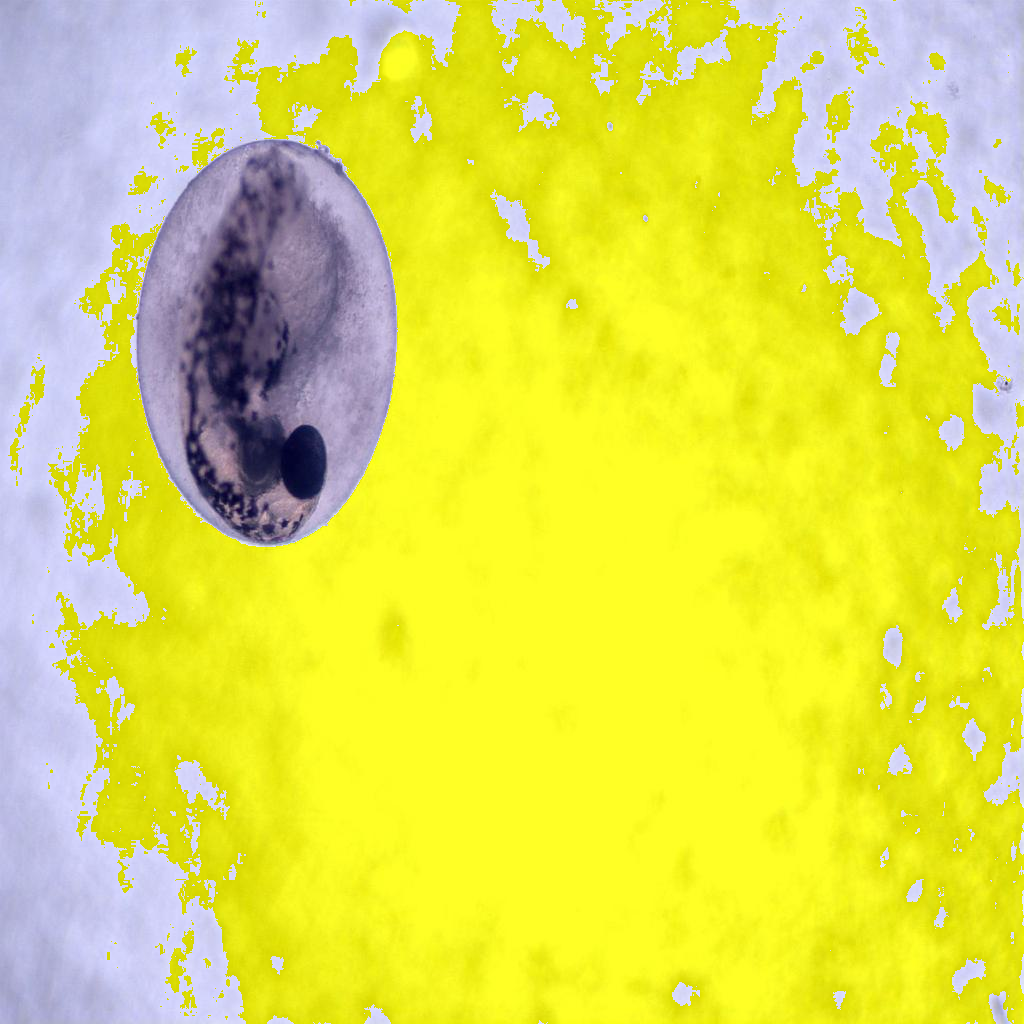

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import ImageOps, Image
from matplotlib import cm

# Define class names
class_names = ["Curved spine", "Dead", "Edema", "Normal", "Unhatched", "Yolk deformation"]

def get_img_array(img_path, size):
    img = Image.open(img_path).convert('RGB')
    img = ImageOps.fit(img, size, Image.Resampling.LANCZOS)
    img_array = np.asarray(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = (img_array.astype(np.float32) / 127.5) - 1
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_indices):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        tape.watch(last_conv_layer_output)

        class_channel = tf.gather(preds[0], pred_indices)

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    heatmaps = []
    for i in range(len(pred_indices)):
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())

    return heatmaps

def save_and_display_gradcam(img_path, heatmaps, pred_indices, cam_path_prefix="cam", alpha=0.3):
    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)

    for i, heatmap in enumerate(heatmaps):
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = Image.fromarray(np.uint8(jet_heatmap * 255))
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = np.asarray(jet_heatmap)

        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = Image.fromarray(np.uint8(superimposed_img))

        cam_path = f"{cam_path_prefix}_{class_names[pred_indices[i]]}.jpg"
        superimposed_img.save(cam_path)
        display(superimposed_img)

def grad_cam(fname, model):
    img_array = get_img_array(fname, size=(224, 224))

    preds = model.predict(img_array)
    pred_bool = (preds > 0.5).astype(int).ravel()

    print(pred_bool)

    print("This image has labels:")
    pred_indices = []
    for i, class_name in enumerate(class_names):
        if pred_bool[i] == 1:
            print(f'  - {class_name}')
            pred_indices.append(i)

    if not pred_indices:
        print("No positive predictions to generate heatmaps for.")
        return

    print(pred_indices)

    heatmaps = make_gradcam_heatmap(img_array, model, 'conv5_block3_out', pred_indices)
    save_and_display_gradcam(fname, heatmaps, pred_indices)

fname = "/content/drive/MyDrive/test2/10.jpg"
grad_cam(fname, resnet_FT)


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

last_conv_layer_name = "conv5_block3_out"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, resnet_FT, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
from keras.applications.resnet_v2 import preprocess_input, decode_predictions

def gradCAM(model, orig, intensity=0.5, res=250):
    DIM = 224
    img = keras.preprocessing.image.load_img(orig, target_size=(DIM, DIM))
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer("conv5_block3_out")
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heatmap = tf.reduce_max(heatmap)
    if max_heatmap != 0:
        heatmap /= max_heatmap
    heatmap = heatmap.numpy().squeeze()

    print(f"Heatmap shape: {heatmap.shape}")  # Debugging statement
    print(f"Heatmap values range: {np.min(heatmap)} to {np.max(heatmap)}")  # Debugging statement

    img = cv2.imread(orig)
    if img is None:
        raise ValueError("Could not read the image. Check the file path.")

    print(f"Original image shape: {img.shape}")  # Debugging statement

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Ensure heatmap is CV_8UC1
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(heatmap, intensity, img, 1 - intensity, 0)

    cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
gradCAM(model, "data_one_hot/images/0,5-004.jpg")

1/1 [==============================] - 1s 517ms/step
Heatmap shape: (7, 7)
Heatmap values range: 0.01363372802734375 to 1.0
Original image shape: (1280, 1920, 3)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:3940: error: (-215:Assertion failed) func != 0 in function 'resize'


<ipython-input-76-51653199b054>:39: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
<ipython-input-76-51653199b054>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


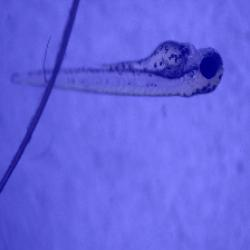

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

last_conv_layer_name = "conv5_block3_out"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.8):
    img = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    return superimposed_img

model = tf.keras.applications.ResNet50(weights='imagenet')

img = cv2.imread("data_one_hot/images/0,5-005.jpg")
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img, resnet_FT, 'conv5_block3_out')
#heatmap = cv2.resize(heatmap, (150, 150))
img = test_images[1]
img = cv2.resize(img, (250,250))
superimposed_img = save_and_display_gradcam(img, heatmap)

In [ ]:
def get_img_array(img_path, size):

    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argsort(preds[0], direction='DESCENDING')[:3]  # Top 3 predicted classes
        class_channels = [preds[:, i] for i in pred_index]

    heatmaps = []
    for class_channel in class_channels:
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())

    return heatmaps

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))


#model = tf.keras.applications.ResNet50(weights='imagenet')
last_conv_layer_name =  'conv5_block3_out'

img_path = "data_one_hot/images/0,5-003.jpg"
heatmaps = make_gradcam_heatmap(get_img_array(img_path, size=(224, 224)), resnet_FT, last_conv_layer_name)

for i, heatmap in enumerate(heatmaps):
    save_and_display_gradcam(img_path, heatmap, cam_path=f"cam_{i}.jpg")

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    heatmaps = []
    for index in pred_index:
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())

    return heatmaps

last_conv_layer_name =  'dense_3'
# Generate heatmaps for each predicted class
pred_index = [0, 1, 2]  # Example: Top 3 predicted classes
heatmaps = make_gradcam_heatmap(get_img_array(img_path, size=(224, 224)), resnet_FT, last_conv_layer_name, pred_index)

# Save and display the Grad-CAM for each class
for i, heatmap in enumerate(heatmaps):
    save_and_display_gradcam(img_path, heatmap, cam_path=f"cam_{pred_index[i]}.jpg")


InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (2 for input with 2 dimension(s) [Op:Mean]

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image as keras_image
import cv2
from google.colab.patches import cv2_imshow

class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model(
            [self.model.inputs],
            [self.model.get_layer(self.layer_name).output, self.model.output]
        )

    def compute_heatmap(self, img_array):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            loss = predictions[:, tf.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_outputs)[0]
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap  # usunięto .numpy()

def preprocess_image(image_path, target_size):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def overlay_heatmap(img_path, heatmap, intensity=0.5, res=250):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Could not read the image. Check the file path.")

    #heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, intensity, img, 1 - intensity, 0)
    cv2_imshow(cv2.resize(img, (res, res)))
    cv2_imshow(cv2.resize(superimposed_img, (res, res)))

# Example usage:
model = tf.keras.applications.ResNet50(weights='imagenet')
image_path = "data_one_hot/images/0,5-005.jpg"
preprocessed_img = preprocess_image(image_path, target_size=(224, 224))

icam = GradCAM(model, 'conv5_block3_out')
heatmap = icam.compute_heatmap(preprocessed_img)
overlay_heatmap(image_path, heatmap)

<ipython-input-145-997c1b3cd392>:25: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-145-997c1b3cd392>:41: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


error: OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from keras.models import Model

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

# Example usage
icam = GradCAM(resnet_FT, i, 'conv5_block3_out')

image = cv2.imread("data_one_hot/images/0,5-005.jpg")
image = cv2.resize(image, (224, 224))  # Resize image to match model input shape
#image = np.expand_dims(image, axis=0)  # Add batch dimension
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))  # Resize heatmap to match image size

(heatmap, output) = icam.overlay_heatmap(heatmap, image[0], alpha=0.5)  # Remove batch dimension when overlaying heatmap

# Display the result
fig, ax = plt.subplots(1, 3)
ax[0].imshow(heatmap)
ax[1].imshow(image[0])
ax[2].imshow(output)


ValueError: Input 0 of layer "model_117" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)

In [ ]:
from keras import backend as K
import scipy

gap_weights = resnet_FT.layers[-1].get_weights()[0]
print(" >>> size(gap_weights) = ", gap_weights.size)

cam_model = Model(inputs=resnet_FT.input,
                    outputs=(resnet_FT.layers[-3].output, resnet_FT.layers[-1].output))
print(" >>> K.int_shape(model.layers[-3].output) = ", K.int_shape(resnet_FT.layers[-3].output))
print(" >>> K.int_shape(model.layers[-1].output) = ", K.int_shape(resnet_FT.layers[-1].output))

#--- make the prediction
features, results = cam_model.predict(test_gen)

fashion_name = class_names

NameError: name 'resnet_FT' is not defined

 >>> size(gap_weights) =  6144
 >>> K.int_shape(model.get_layer(last_conv_layer).output) =  (None, 7, 7, 2048)
 >>> K.int_shape(model.layers[-1].output) =  (None, 6)
1/1 [==============================] - 3s 3s/step
conv5_block3_out


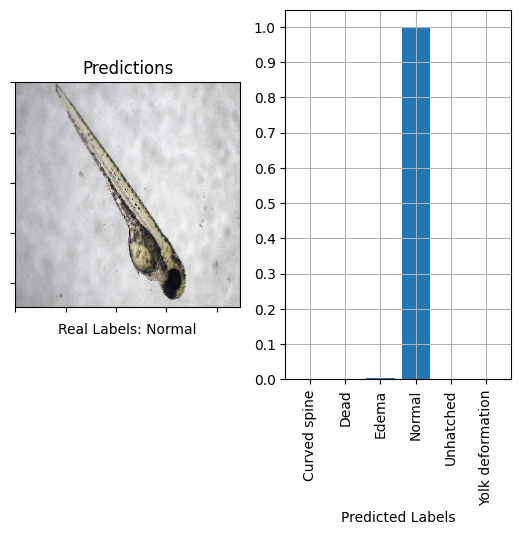

 >>>  [0.       0.       0.003405 0.999    0.       0.      ]
 >>> features[idx].shape =  (1024,)


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
from keras.models import Model
from keras import backend as K
import scipy
from keras.applications.resnet50 import preprocess_input

# Load the model
model = resnet_FT

gap_weights = model.layers[-1].get_weights()[0]
print(" >>> size(gap_weights) = ", gap_weights.size)

# Find the last convolutional layer
for layer in model.layers[::-1]:
    if 'conv' in layer.name or 'Conv' in layer.name:
        last_conv_layer = layer.name
        break

# Create a model that outputs the features and the predictions
cam_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output, model.layers[-1].output))
print(" >>> K.int_shape(model.get_layer(last_conv_layer).output) = ", K.int_shape(model.get_layer(last_conv_layer).output))
print(" >>> K.int_shape(model.layers[-1].output) = ", K.int_shape(model.layers[-1].output))

# Predict on a batch of test images
test_img, test_labels = next(test_gen)
features, results = cam_model.predict(test_img)

print(last_conv_layer)

def plot_gradcam(test_img, features, results, gap_weights, class_names, idx=0):
    plt.figure(facecolor='white')

    ax = plt.subplot(1, 2, 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(test_img[idx])

    real_labels = [class_names[i] for i, val in enumerate(test_labels[idx]) if val > 0.5]
    plt.xlabel("Real Labels: " + ", ".join(real_labels))
    predicted_probs = results[idx]
    plt.title("Predictions")

    plt.subplot(1, 2, 2)
    plt.bar(range(len(class_names)), predicted_probs)
    plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Predicted Labels")
    plt.grid()

    plt.show()

    print(" >>> ", results[idx])

    print(" >>> features[idx].shape = ", features[idx].shape)

    features_for_one_img = features[idx, :, :, :]
    print(" >>> features_for_one_img.shape = ", features_for_one_img.shape)
    print(" >>> features_for_one_img.shape[0] = ", features_for_one_img.shape[0])
    print(" >>> features_for_one_img.shape[1] = ", features_for_one_img.shape[1])

    height_roomout = int(224 / features_for_one_img.shape[0])
    width_roomout = int(224 / features_for_one_img.shape[1])

    print(" >>> height_roomout = ", height_roomout, " width_roomout = ", width_roomout)

    cam_features = scipy.ndimage.zoom(features_for_one_img.astype('float32'), (height_roomout, width_roomout, 1), order=2)

    print(" >>> after resize = ", cam_features.shape)

    x = np.argsort(results[idx])
    print(" (x) = ", x)

    plt.figure(facecolor='white')

    for i in range(1, 5):

        pred = x[0-i]
        print(" >>> i = ", i, " pred = ", pred)

        cam_weights = gap_weights[:, pred]

        # Ensure the dimensions are aligned
        if cam_features.shape[-1] != cam_weights.shape[0]:
            print(f"Skipping due to shape mismatch: cam_features.shape[-1]={cam_features.shape[-1]}, cam_weights.shape[0]={cam_weights.shape[0]}")
            continue

        # Transpose cam_features to match the dimensions for dot product
        cam_features_transpose = np.transpose(cam_features, (2, 0, 1))
        cam_output = np.dot(cam_features_transpose, cam_weights)

        ax = plt.subplot(4, 1, i)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        buf = 'Predicted Class = ' + class_names[pred] + ', Probability = ' + str(results[idx][pred])
        plt.xlabel(buf)

        plt.imshow(test_img[idx], alpha=0.5)
        plt.imshow(cam_output, cmap='jet', alpha=0.5)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

# Check the prediction and GradCAM for a few test images
for idx in range(2):
    plot_gradcam(test_img, features, results, gap_weights, class_names, idx)

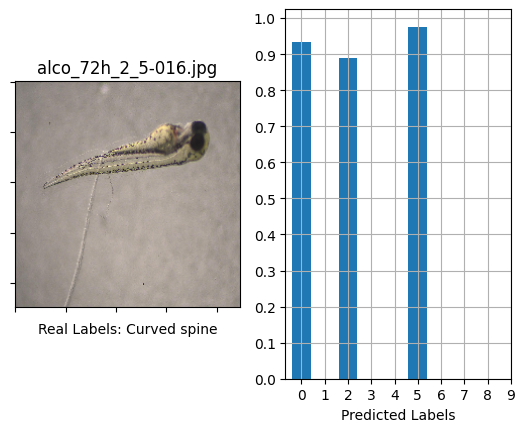

 >>>  [9.351e-01 0.000e+00 8.906e-01 3.753e-04 0.000e+00 9.761e-01]
 >>> features[idx].shape =  (7, 7, 2048)
 >>> features_for_one_img.shape =  (7, 7, 2048)
 >>> features_for_one_img.shape[0] =  7
 >>> features_for_one_img.shape[1] =  7
 >>> height_roomout =  32.0  width_roomout =  32.0
 >>> after resize =  (224, 224, 2048)
 (n, v) =  0 0.935
 (n, v) =  1 0.0
 (n, v) =  2 0.8906
 (n, v) =  3 0.0003753
 (n, v) =  4 0.0
 (n, v) =  5 0.976
 (x) =  [1 4 3 2 0 5]
 >>> i =  1  pred =  5


ValueError: shapes (224,224,2048) and (1,1,1024) not aligned: 2048 (dim 2) != 1 (dim 1)

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx in range(30):
    plt.figure(facecolor='white')

    ax = plt.subplot(1, 2, 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(test_gen[idx][0][0])  # Display original test image
    plt.xlabel("Real Labels: " + class_names[idx])
    plt.title(test_gen.filenames[idx])

    plt.subplot(1, 2, 2)
    plt.bar(range(6), results[idx])
    plt.xticks(np.arange(0, 9.1, 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Predicted Labels")
    plt.grid()
    plt.show()

    print(" >>> ", results[idx])

    print(" >>> features[idx].shape = ", features[idx].shape)

    features_for_one_img = features[idx, :, :, :]
    print(" >>> features_for_one_img.shape = ", features_for_one_img.shape)
    print(" >>> features_for_one_img.shape[0] = ", features_for_one_img.shape[0])
    print(" >>> features_for_one_img.shape[1] = ", features_for_one_img.shape[1])

    height_roomout = 224 / features_for_one_img.shape[0]
    width_roomout = 224 / features_for_one_img.shape[1]

    print(" >>> height_roomout = ", height_roomout, " width_roomout = ", width_roomout)

    cam_features = scipy.ndimage.zoom(features_for_one_img.astype('float32'), (height_roomout, width_roomout, 1), order=2)

    print(" >>> after resize = ", cam_features.shape)

    for n, v in enumerate(results[idx]):
        print(" (n, v) = ", n , v)

    x = np.argsort(results[idx])
    print(" (x) = ", x)

    plt.figure(facecolor='white')

    for i in range(1, 5):

        pred = x[0-i]
        print(" >>> i = ", i, " pred = ", pred)

        cam_weights = gap_weights[:, pred]
        cam_weights = cam_weights.reshape(1, 1, -1)  # Reshape to match cam_features

        cam_output = np.dot(cam_features, cam_weights)

        ax = plt.subplot(4, 1, i)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        buf = 'Predicted Class = ' + fashion_name[pred] + ', Probability = ' + str(results[idx][pred])
        plt.xlabel(buf)

        plt.imshow(t_pic[idx], alpha=0.5)
        plt.imshow(cam_output, cmap='jet', alpha=0.5)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    plt.show()

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Model
from keras.applications import ResNet50V2
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

# Load and preprocess the image
img_path = 'data_one_hot/images/0,5-002.jpg'
original_img = load_img(img_path, target_size=(224, 224))
img = img_to_array(original_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)


# Get the model's prediction
preds = model.predict(img)
predicted_class = np.argmax(preds[0])

# Get the gradient of the predicted class with respect to the output feature map
with tf.GradientTape() as tape:
    last_conv_layer_output = tf.convert_to_tensor(model.get_layer('conv5_block3_out').output)
    #tape.watch(last_conv_layer_output)  # Watch the output tensor
    target_class_output = model.output[:, predicted_class]
    grads = tape.gradient(target_class_output, last_conv_layer_output)

# Calculate the mean intensity of the gradient over each feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map array by "how important this channel is" with regard to the predicted class
heatmap = tf.reduce_mean(tf.multiply(pooled_grads[..., tf.newaxis], last_conv_layer_output), axis=-1)

# Normalize the heatmap
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

# Resize the heatmap to the size of the original image
heatmap = tf.image.resize(heatmap, (original_img.size[1], original_img.size[0]))

# Convert heatmap to numpy array
heatmap = heatmap.numpy()

# Overlay the heatmap onto the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

# Save the result
cv2.imwrite('heatmap.jpg', superimposed_img)

1/1 [==============================] - 1s 1s/step


ValueError: Exception encountered when calling layer "tf.__operators__.getitem" (type SlicingOpLambda).

slice index 37752 of dimension 1 out of bounds. for '{{node tf.__operators__.getitem/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_HALF, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2](Placeholder, tf.__operators__.getitem/strided_slice/stack, tf.__operators__.getitem/strided_slice/stack_1, tf.__operators__.getitem/strided_slice/stack_2)' with input shapes: [?,7,7,2048], [2], [2], [2] and with computed input tensors: input[1] = <0 37752>, input[2] = <0 37753>, input[3] = <1 1>.

Call arguments received by layer "tf.__operators__.getitem" (type SlicingOpLambda):
  • tensor=tf.Tensor(shape=(None, 7, 7, 2048), dtype=float16)
  • slice_spec=({'start': 'None', 'stop': 'None', 'step': 'None'}, '37752')
  • var=None

# Transfer-Learning InceptionV3

In [77]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [83]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
], name="data_augmentation")

def build_model(num_classes):
    inputs = layers.Input(shape=(299, 299, 3))
    x = data_augmentation(inputs)
    model = keras.applications.InceptionV3(include_top=False, input_tensor=x, weights="imagenet", classes=num_classes)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation="relu")(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2
    )
    return model

model3 = build_model(num_classes=6)
resnet_history3 = model.fit(train_data,
            epochs=15,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks=model_earlystop_callback)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/15
106/106 [==============================] - 132s 1s/step - loss: 0.1436 - f1_score: 0.7503 - precision: 0.8293 - recall: 0.7937 - auc: 0.9697 - prc: 0.9005 - val_loss: 0.1401 - val_f1_score: 0.7364 - val_precision: 0.8988 - val_recall: 0.8623 - val_auc: 0.9791 - val_prc: 0.9437
Epoch 2/15
106/106 [==============================] - 130s 1s/step - loss: 0.1324 - f1_score: 0.7616 - precision: 0.8592 - recall: 0.8019 - auc: 0.9745 - prc: 0.9139 - val_loss: 0.2364 - val_f1_score: 0.7049 - val_precision: 0.8527 - val_recall: 0.6795 - val_auc: 0.9559 - val_prc: 0.8612
Epoch 3/15
106/106 [==============================] - 121s 1s/step - loss: 0.1163 - f1_score: 0.7691 - precision: 0.8614 - recall: 0.8229 - auc: 0.9789 - prc: 0.9251 - val_loss: 0.1656 - val_f1_score: 0.7341 - val_precision: 0.8671 - val_recall: 0.8104 - val_auc: 0.9735 - val_prc: 0.9202
Epoch 4/15
106/106 [==============================] - 116s 1s/step -

14/14 [==============================] - 14s 1s/step


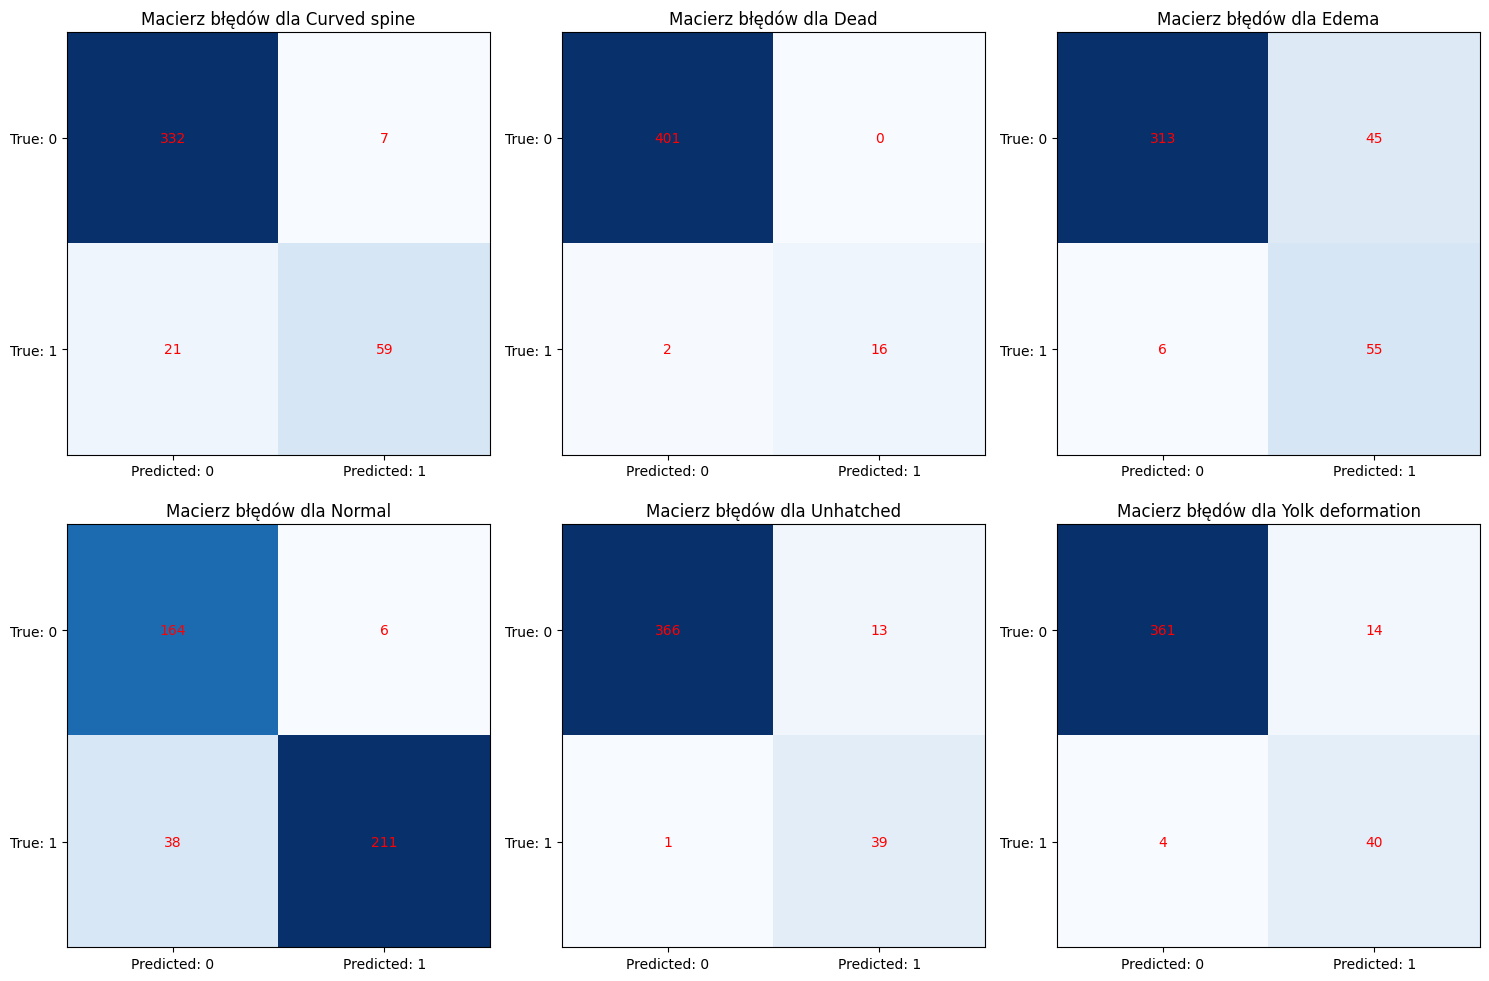

In [84]:
pred=model.predict(test_gen, verbose=1)
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

In [ ]:
model3.evaluate(test_gen)

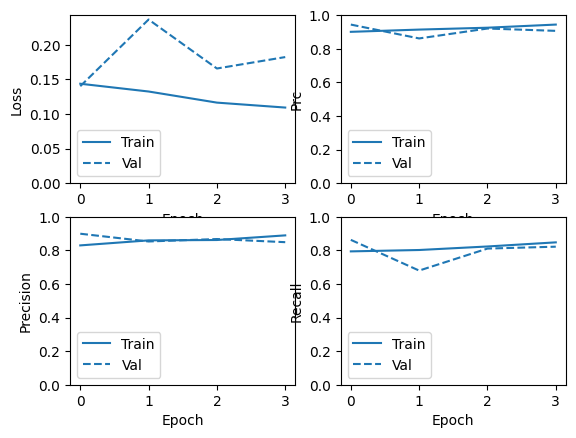

In [85]:
plot_metrics(resnet_history3)

In [1]:
showF1scores(model3, test_gen, class_names)

NameError: name 'showF1scores' is not defined

In [ ]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

In [ ]:
model3.save('drive/MyDrive/Colab Notebooks/Inception_BestSoFar/')

In [ ]:
test_gen.reset()

# Fine-tuning InceptionV3

In [ ]:
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
], name="data_augmentation")


inputs = layers.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
base_model = keras.applications.InceptionV3(include_top=False, input_tensor=x, weights="imagenet", classes=6)

    # Freeze the pretrained weights
for layer in base_model.layers[:]:
  layer.trainable = False

    # Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu")(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="sigmoid", name="pred")(x)

# Compile
inception = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.001)
inception.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2
)

inception_history = inception.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = model_earlystop_callback)


Epoch 1/10
106/106 [==============================] - 158s 1s/step - loss: 0.4208 - f1_score: 0.6028 - precision: 0.6606 - recall: 0.6668 - auc: 0.8994 - prc: 0.7318 - val_loss: 0.2376 - val_f1_score: 0.6666 - val_precision: 0.7372 - val_recall: 0.6524 - val_auc: 0.9425 - val_prc: 0.8135
Epoch 2/10
106/106 [==============================] - 122s 1s/step - loss: 0.2720 - f1_score: 0.6775 - precision: 0.7539 - recall: 0.7086 - auc: 0.9311 - prc: 0.8101 - val_loss: 0.2220 - val_f1_score: 0.7020 - val_precision: 0.8055 - val_recall: 0.6637 - val_auc: 0.9502 - val_prc: 0.8441
Epoch 3/10
106/106 [==============================] - 122s 1s/step - loss: 0.2316 - f1_score: 0.6901 - precision: 0.7811 - recall: 0.7216 - auc: 0.9400 - prc: 0.8302 - val_loss: 0.1839 - val_f1_score: 0.7287 - val_precision: 0.8553 - val_recall: 0.7607 - val_auc: 0.9681 - val_prc: 0.8887
Epoch 4/10
106/106 [==============================] - 115s 1s/step - loss: 0.1934 - f1_score: 0.7172 - precision: 0.7934 - recall: 0.

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 data_augmentation False
2 conv2d_188 False
3 batch_normalization_190 False
4 activation_188 False
5 conv2d_189 False
6 batch_normalization_191 False
7 activation_189 False
8 conv2d_190 False
9 batch_normalization_192 False
10 activation_190 False
11 max_pooling2d_8 False
12 conv2d_191 False
13 batch_normalization_193 False
14 activation_191 False
15 conv2d_192 False
16 batch_normalization_194 False
17 activation_192 False
18 max_pooling2d_9 False
19 conv2d_196 False
20 batch_normalization_198 False
21 activation_196 False
22 conv2d_194 False
23 conv2d_197 False
24 batch_normalization_196 False
25 batch_normalization_199 False
26 activation_194 False
27 activation_197 False
28 average_pooling2d_18 False
29 conv2d_193 False
30 conv2d_195 False
31 conv2d_198 False
32 conv2d_199 False
33 batch_normalization_195 False
34 batch_normalization_197 False
35 batch_normalization_200 False
36 batch_normalization_201 False
37 activation_193 False
38 activation_195 False
39 activat

In [ ]:
for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 data_augmentation False
2 conv2d_188 False
3 batch_normalization_190 False
4 activation_188 False
5 conv2d_189 False
6 batch_normalization_191 False
7 activation_189 False
8 conv2d_190 False
9 batch_normalization_192 False
10 activation_190 False
11 max_pooling2d_8 False
12 conv2d_191 False
13 batch_normalization_193 False
14 activation_191 False
15 conv2d_192 False
16 batch_normalization_194 False
17 activation_192 False
18 max_pooling2d_9 False
19 conv2d_196 False
20 batch_normalization_198 False
21 activation_196 False
22 conv2d_194 False
23 conv2d_197 False
24 batch_normalization_196 False
25 batch_normalization_199 False
26 activation_194 False
27 activation_197 False
28 average_pooling2d_18 False
29 conv2d_193 False
30 conv2d_195 False
31 conv2d_198 False
32 conv2d_199 False
33 batch_normalization_195 False
34 batch_normalization_197 False
35 batch_normalization_200 False
36 batch_normalization_201 False
37 activation_193 False
38 activation_195 False
39 activat

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
inception.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS2)

inception_history_FT = inception.fit(
            train_data,
            epochs=30,
            initial_epoch=inception_history.epoch[-1],
            steps_per_epoch=len(train_data),
            validation_data=validation_gen,
            validation_steps=len(validation_gen),
            class_weight=class_weights_calc,
            callbacks = [model_earlystop_callback, model_checkpoint_callback])

Epoch 6/30
106/106 [==============================] - ETA: 0s - loss: 0.1865 - f1_score: 0.7231 - precision: 0.8031 - recall: 0.7706 - auc: 0.9568 - prc: 0.8705
Epoch 6: val_loss improved from inf to 0.19101, saving model to drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint
106/106 [==============================] - 139s 1s/step - loss: 0.1865 - f1_score: 0.7231 - precision: 0.8031 - recall: 0.7706 - auc: 0.9568 - prc: 0.8705 - val_loss: 0.1910 - val_f1_score: 0.7669 - val_precision: 0.8892 - val_recall: 0.8510 - val_auc: 0.9757 - val_prc: 0.9282
Epoch 7/30
106/106 [==============================] - ETA: 0s - loss: 0.1366 - f1_score: 0.7528 - precision: 0.8485 - recall: 0.8190 - auc: 0.9718 - prc: 0.9104
Epoch 7: val_loss improved from 0.19101 to 0.16525, saving model to drive/MyDrive/Colab Notebooks/TransferLearning/tmp/checkpoint
106/106 [==============================] - 120s 1s/step - loss: 0.1366 - f1_score: 0.7528 - precision: 0.8485 - recall: 0.8190 - auc: 0.9718 - p

In [ ]:
inception.load_weights(checkpoint_filepath)

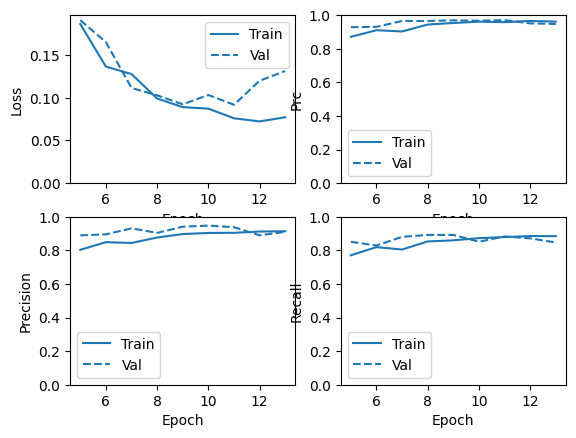

In [ ]:
plot_metrics(inception_history_FT)

In [ ]:
test_gen.reset()

In [ ]:
inception.save('drive/MyDrive/Colab Notebooks/Inception_FT_BestSoFar2/')

In [ ]:
inception.save('drive/MyDrive/Colab Notebooks/Inception_FT_BestSoFar2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
resnet_FT = tf.keras.saving.load_model('drive/MyDrive/Colab Notebooks/Inception_FT_BestSoFar2/')

14/14 [==============================] - 99s 7s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


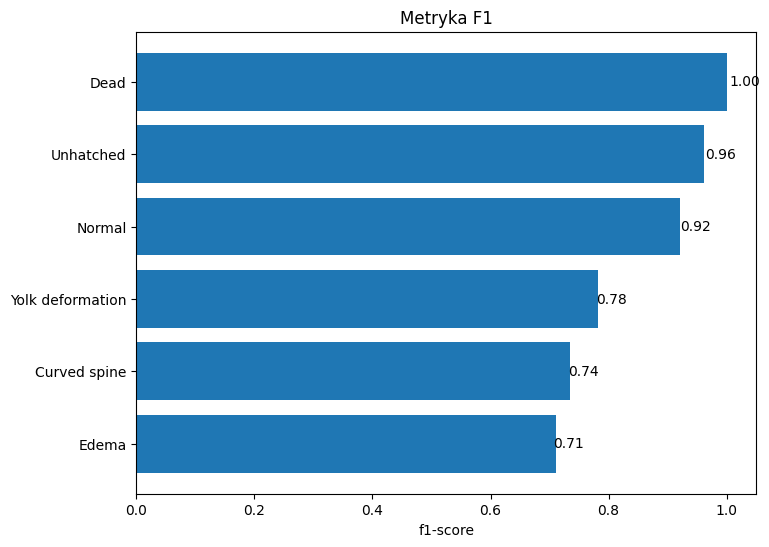

In [ ]:
showF1scores(resnet_FT, test_gen, class_names)

In [ ]:
resnet_FT.evaluate(test_gen)

14/14 [==============================] - 17s 1s/step - loss: 0.1133 - f1_score: 0.7954 - precision: 0.9015 - recall: 0.8740 - auc: 0.9856 - prc: 0.9567


[0.11325619369745255,
 0.7953982353210449,
 0.901467502117157,
 0.8739837408065796,
 0.9856406450271606,
 0.9566729068756104]

In [ ]:
pred=resnet_FT.predict(test_gen,
steps=len(test_gen),
verbose=1)

14/14 [==============================] - 102s 7s/step


1/1 [==============================] - 1s 1s/step
Prediction: Curved spine 0.00%, True: 0
Prediction: Dead 0.00%, True: 0
Prediction: Edema 91.26%, True: 0
Prediction: Normal 0.05%, True: 0
Prediction: Unhatched 100.00%, True: 1
Prediction: Yolk deformation 3.09%, True: 0


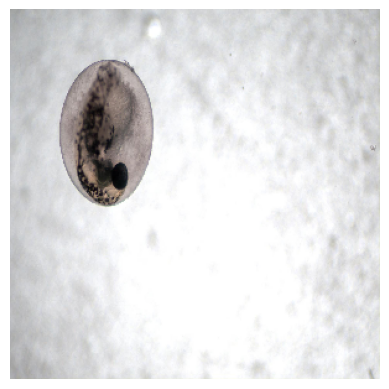

In [ ]:
random_number = random.randint(0, 31)
pred_and_plot(model=resnet_FT, filename=test_images[9], true_label=test_gen.labels[9], class_names= class_names)

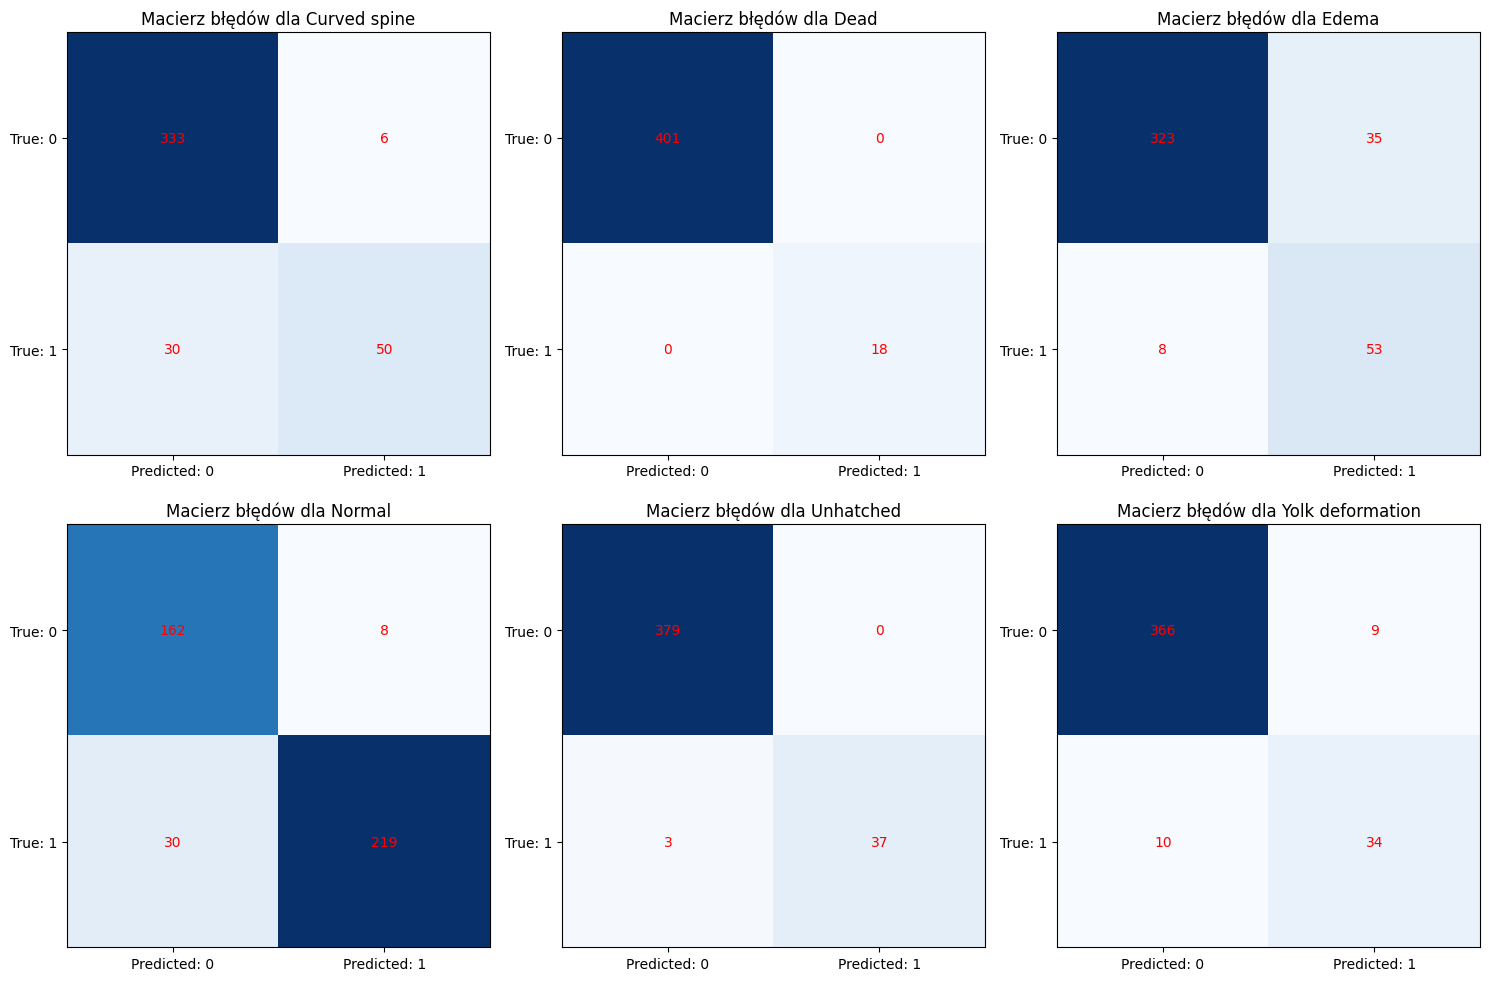

In [ ]:
preds = np.where(pred < 0.5, 0, 1)
plot_multi_label_confusion_matrix(test_gen.labels, preds, class_names)

In [ ]:
print(classification_report(test_gen.labels, preds, target_names = class_names))

                  precision    recall  f1-score   support

    Curved spine       0.89      0.62      0.74        80
            Dead       1.00      1.00      1.00        18
           Edema       0.60      0.87      0.71        61
          Normal       0.96      0.88      0.92       249
       Unhatched       1.00      0.93      0.96        40
Yolk deformation       0.79      0.77      0.78        44

       micro avg       0.88      0.84      0.86       492
       macro avg       0.88      0.85      0.85       492
    weighted avg       0.90      0.84      0.86       492
     samples avg       0.84      0.85      0.84       492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
